In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier


from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression, RFECV


from tpot import TPOTRegressor

from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO, inflammatory_attributes, igf_associated_features
from main.components.preprocessing_methods import remove_outliers, get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model
from main.components.feature_importance_methods import get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf, get_feature_importance_knn, rename_importnace_col, merge_feature_importances, rank_importances, feature_selection_mutual_info_regression, recursive_feature_elimination, get_permutation_importance



import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
raw_df = pd.read_csv(dataset_file_path)
raw_df.sample(5)

PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro  IGF-1 ng/ml (N: 100-311)  proBNP  AMH (ng/ml) *7,14=pmol/l  weight  height (cm)        BMI  systolic BP (ciśnienie skurczowe)  diastolic BP (ciśnienie rozskurczowe)  Hypertension  Waist Circumference (WC)  WC>88  Hip Circumference (HC)  WHR (Waist/Hip ratio)  WHR>0,85 (WHO)  WHR>0,8 (NIDDK)  WHTR (Waist/Height Ratio)  WHTR>0,5  overweight/obesity 0-normal/low, 1-overweight, 2-obesity  irregular cycles (0-nie, 1-tak)  ovulation (0-brak, 1-obecna)  PCO ovary morfology in USG (0-brak, 1--obecna)  stromal hypertrophy in ovary (0-brak, 1-obecny)  acne  hirsutism  FG score (Ferriman-Gallway score - stopień androgenizacji)  hyperandrogenism  hypothyroidism  Volume of the thyroid  Right Lobe  Volume of the thyroid  Left Lobe  thyroid volume  nodules 0-lack, 1-RL,  2-LL, 3-both  chronic thyroiditis  Vole of the Right Ovary  Volume of the  Left Ovary  ovaries volume - total  follicules >12  WBC x10^3/ul  neutrophil x10^3/ul  \
737                                                         1                     204.0   38.14                  5.159664   135.0        172.0  45.632774                              160.0                                  110.0           1.0                     104.0    1.0                   137.0               0.759124             0.0              0.0                   0.604651       1.0                                                       2.0                              1.0                           0.0                                             0.0                                              1.0   0.0        1.0                                                        22.0               0.0             1.0                             6.0720                           6.17400        12.24600                                  0.0                  1.0                     9.76                       8.86                   18.62             0.0          4.61                 2.50   
263                                                         1                     274.0   61.04                  4.866947    57.0        166.0  20.685150                              109.0                                   70.0           0.0                      65.0    0.0                    85.0               0.764706             0.0              0.0                   0.391566       0.0                                                       0.0                              1.0                           0.0                                             1.0                                              0.0   1.0        0.0                                                         1.0               0.0             0.0                             4.5900                           2.57400         7.16400                                  0.0                  0.0                    17.34                      11.80                   29.14             1.0          6.51                 2.85   
946                                                         4                       NaN     NaN                       NaN    71.0        167.0  25.458066                              129.0                                   77.0           0.0                       NaN    NaN                     NaN                    NaN             NaN              NaN                        NaN       NaN                                                       1.0                              0.0                           0.0                                             0.0                                              NaN   NaN        1.0                                                         NaN               1.0             NaN                            54.3186                           5.13009        59.44869                                  NaN                  NaN                     8.20                       9.49                   17.69             0.0          6.78                 3.75   
383                          

Left only the values within the interval: [-11.26, 499.68]
Removed 8 outlier values of IGF-1 ng/ml (N: 100-311) -> 1.26 % of all the not null examples


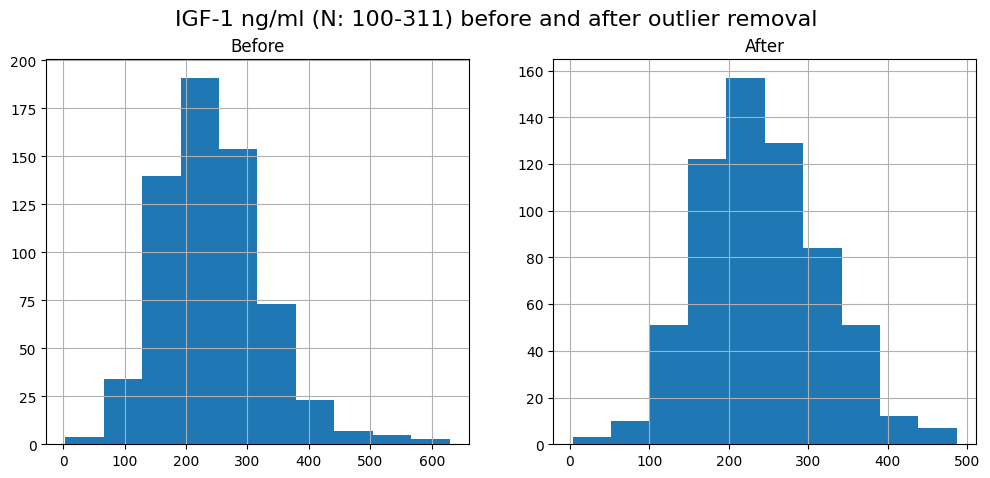

In [3]:
df = remove_outliers(raw_df, IGF)

In [4]:
df_igf_cleaned = df.dropna(subset=[IGF])

X_igf, y_igf = df_igf_cleaned.drop(columns=[IGF]), df_igf_cleaned[IGF]
X_train_igf, X_test_igf, y_train_igf, y_test_igf = train_test_split(X_igf, y_igf, test_size=0.2, random_state=42)

In [5]:
continuous_preprocessor = Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))])
tree_continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])

# categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])
categorical_preprocessor = Pipeline([('imputer', IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=10, n_jobs=-1), max_iter=40, initial_strategy='most_frequent')), ('one_hot_encoder', OneHotEncoder(handle_unknown='error', drop='if_binary'))])


## Models exploration

In [5]:
# models = [
#         DecisionTreeRegressor(max_depth=7, random_state=42),
#         Lasso(),
#         Ridge(),
#         RandomForestRegressor(),
#         ]

# #  TODO: maybe add DropHighMissingColumns

# continuous_preprocessings = {
#     'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
#     'PT_KNN': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
#     'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
#     'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
# }

# categorical_preprocessings = {
#     # 'custom_ohe_no_imputing': Pipeline([('one_hot_encoder', CustomOneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True))]),
#     'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
#     'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
#     'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
# }


# scores_df = explore_all_variations_of_preprocessing(X_train_igf, y_train_igf, IGF, models, continuous_preprocessings, categorical_preprocessings)

## Hyperparameter tuning

### Lasso

Fitting 15 folds for each of 7 candidates, totalling 105 fits


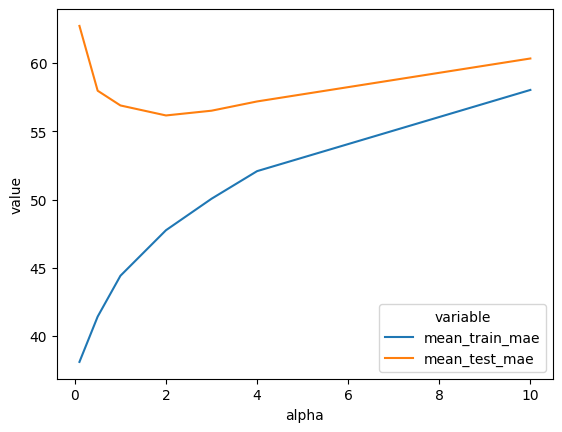

alpha  mean_train_mae  mean_test_mae
0   0.1       38.103286      62.724174
1   0.5       41.424363      57.976270
2     1       44.417298      56.895861
3     2       47.754762      56.163828
4     3       50.060852      56.512038
5     4       52.083143      57.190029
6    10       58.033392      60.337918

In [17]:
param_grid_lasso = {
    'model__alpha': [0.1, 0.5, 1, 2, 3, 4, 10],
}

lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, Lasso(), continuous_preprocessor, categorical_preprocessor, param_grid_lasso, main_parameter='alpha')
lasso_model_hyperparam_tuning_df

Chosen alpha: 1

### KNN

Fitting 15 folds for each of 7 candidates, totalling 105 fits
Best parameters: {'model__n_neighbors': 7}
Best score (neg_mean_absolute_error): -57.42026761904763


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


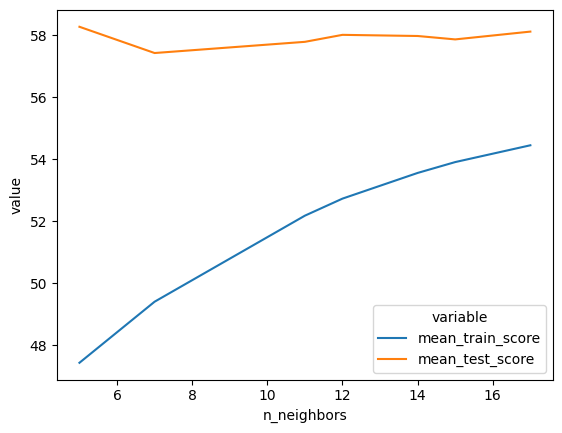

n_neighbors  mean_train_score  mean_test_score
1           7         49.401821        57.420268
2          11         52.176313        57.781143
5          15         53.904106        57.859599
4          14         53.553737        57.969478
3          12         52.725761        58.006374
6          17         54.445598        58.111069
0           5         47.432542        58.266469

In [7]:
from sklearn.neighbors import KNeighborsRegressor

#  NOTE: selected n_neighbours=7

knn_model = KNeighborsRegressor()

knn_param_grid = {
    'model__n_neighbors': [5, 7, 11, 12, 14, 15, 17],  # Number of neighbors to consider
    # 'model__weights': ['uniform', 'distance'],  # Weight function used in prediction
    # 'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    # 'model__leaf_size': [20, 30, 40, 50],  # Leaf size passed to BallTree or KDTree
    # 'model__p': [1, 2]  # Power parameter for Minkowski metric (1 for Manhattan distance, 2 for Euclidean distance)
}

knn_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, knn_model, continuous_preprocessor, categorical_preprocessor, knn_param_grid, main_parameter='n_neighbors')
knn_hyperparam_tuning_df.sort_values(by='mean_test_score')

### Ridge

Fitting 15 folds for each of 8 candidates, totalling 120 fits


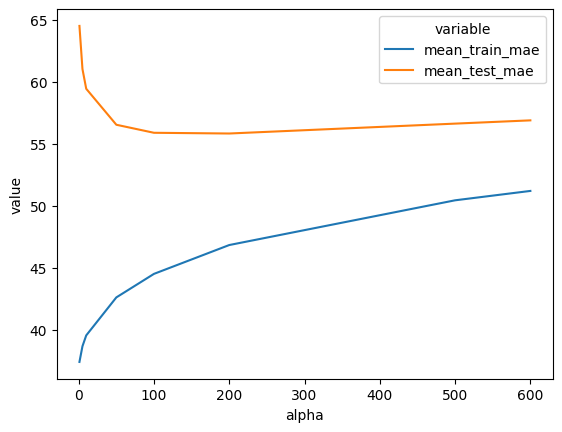

alpha  mean_train_mae  mean_test_mae
0     1       37.413374      64.500115
1     5       38.677579      61.023545
2    10       39.550875      59.433555
3    50       42.614708      56.533328
4   100       44.511782      55.885112
5   200       46.836179      55.827248
6   500       50.442018      56.624161
7   600       51.198200      56.886838

In [19]:
param_grid_ridge = {
    "model__alpha": [1, 5, 10, 50, 100, 200, 500, 600],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, Ridge(), continuous_preprocessor, categorical_preprocessor, param_grid_ridge, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

Chosen alpha: 50

### RandomForest

In [30]:
param_grid_rf = {
    'model__n_estimators': [200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [8, 10, 12],
    'model__min_samples_leaf': [3, 5, 7],
}

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf, y_train_igf, IGF, RandomForestRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 18 candidates, totalling 270 fits


params  mean_train_mae  mean_test_mae
16  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 10, 'model__n_estimators': 200}       41.810143      60.099159
9    {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 200}       31.832130      60.177599
1     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 200}       33.928776      60.182291
10  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 200}       33.874325      60.235325
3      {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 8, 'model__n_estimators': 200}       37.041478      60.241482
4     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}       36.968499      60.250744
6      {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 8, 'model__n_estimators': 200}       41.863576      60.289191
13  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}       36.979434      60.297108
14  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 12, 'model__n_estimators': 200}       38.359807      60.302342
5     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 12, 'model__n_estimators': 200}       38.378933      60.303784
8     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 12, 'model__n_estimators': 200}       41.801936      60.310689
11  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 12, 'model__n_estimators': 200}       35.794937      60.318420
12   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 8, 'model__n_estimators': 200}       37.014351      60.320702
17  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 12, 'model__n_estimators': 200}       41.834482      60.323171
7     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 10, 'model__n_estimators': 200}       41.830270      60.325626
0      {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 200}       31.939967      60.368305
2     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 12, 'model__n_estimators': 200}       35.736612      60.424813
15   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 8, 'model__n_estimators': 200}       41.780765      60.425780

In [11]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=13)

tuned_df = compare_random_states(X_train_igf, y_train_igf, rf_model, IGF, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:22<00:00,  5.68s/it]


cv_mae
56 -60.252833
24 -60.319136
71 -60.389253
67 -60.390057
8  -60.415431

### DecisionTreeRegressor

In [10]:
param_grid_tree = {
    "model__criterion": ["squared_error", "absolute_error"],
    "model__max_depth": [5, 7, 10, 15],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 20, 25, 30],
    "model__min_samples_leaf": [10, 15, 20, 25],
    }

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf, y_train_igf, IGF, DecisionTreeRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_tree)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 128 candidates, totalling 1920 fits


params  mean_train_mae  mean_test_mae
60    {'model__criterion': 'squared_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}       57.744918      64.820633
12     {'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}       57.560372      64.921653
124  {'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}       56.128836      65.008289
126  {'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 25, 'model__splitter': 'random'}       56.347978      65.039668
70    {'model__criterion': 'absolute_error', 'model__max_depth': 5, 'model__min_samples_leaf': 15, 'model__min_samples_split': 25, 'model__splitter': 'random'}       54.164183      65.175315
105  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 20, 'model__splitter': 'random'}       54.071129      65.201847
14     {'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 25, 'model__splitter': 'random'}       58.028373      65.317146
106  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 25, 'model__splitter': 'random'}       54.157504      65.367604
63    {'model__criterion': 'squared_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 30, 'model__splitter': 'random'}       57.440324      65.409121
13     {'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}       58.314826      65.413862
74    {'model__criterion': 'absolute_error', 'model__max_depth': 5, 'model__min_samples_leaf': 20, 'model__min_samples_split': 25, 'model__splitter': 'random'}       56.046721      65.437053
30     {'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_leaf': 25, 'model__min_samples_split': 25, 'model__splitter': 'random'}       57.584050      65.561062
68    {'model__criterion': 'absolute_error', 'model__max_depth': 5, 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__splitter': 'random'}       54.494802      65.620856
84    {'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__splitter': 'random'}       52.416798      65.641603
109  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}       56.098040      65.669238
26     {'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_leaf': 20, 'model__min_samples_split': 25, 'model__splitter': 'random'}       55.675487      65.695743
127  {'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 30, 'model__splitter': 'random'}       56.295925      65.714042
28     {'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}       57.860779      65.812832
29     {'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}       57.939709      65.842100
44    {'model__criterion': 'squared_error', 'model__max_depth': 10, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}       57.160604      65.882672
107  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__spl

In [12]:
model = DecisionTreeRegressor(criterion="squared_error", max_depth=15, min_samples_leaf=25, min_samples_split=15, splitter='random')
	
tuned_df = compare_random_states(X_train_igf, y_train_igf, model, IGF, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [00:42<00:00,  2.31it/s]


cv_mae
16 -63.625855
45 -63.926099
81 -64.088162
88 -64.180902
73 -64.462722

## Best models - IGF

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


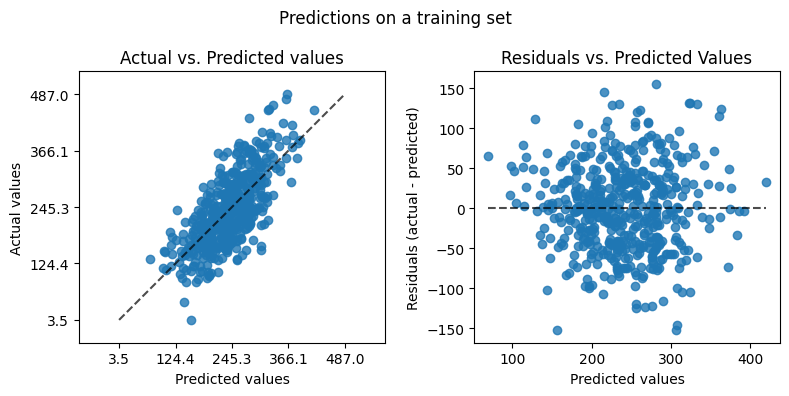

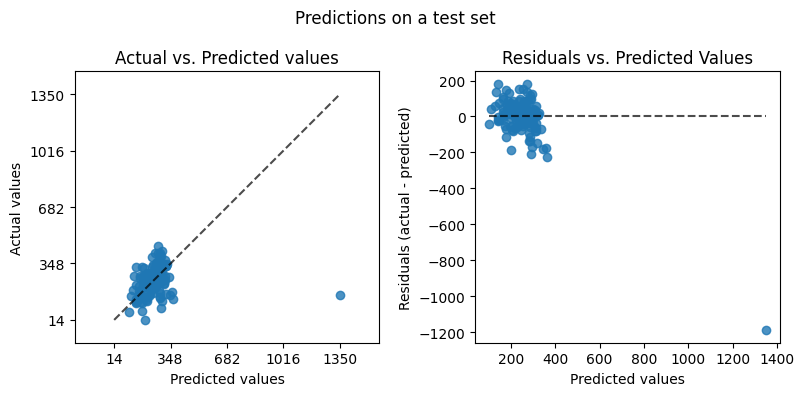

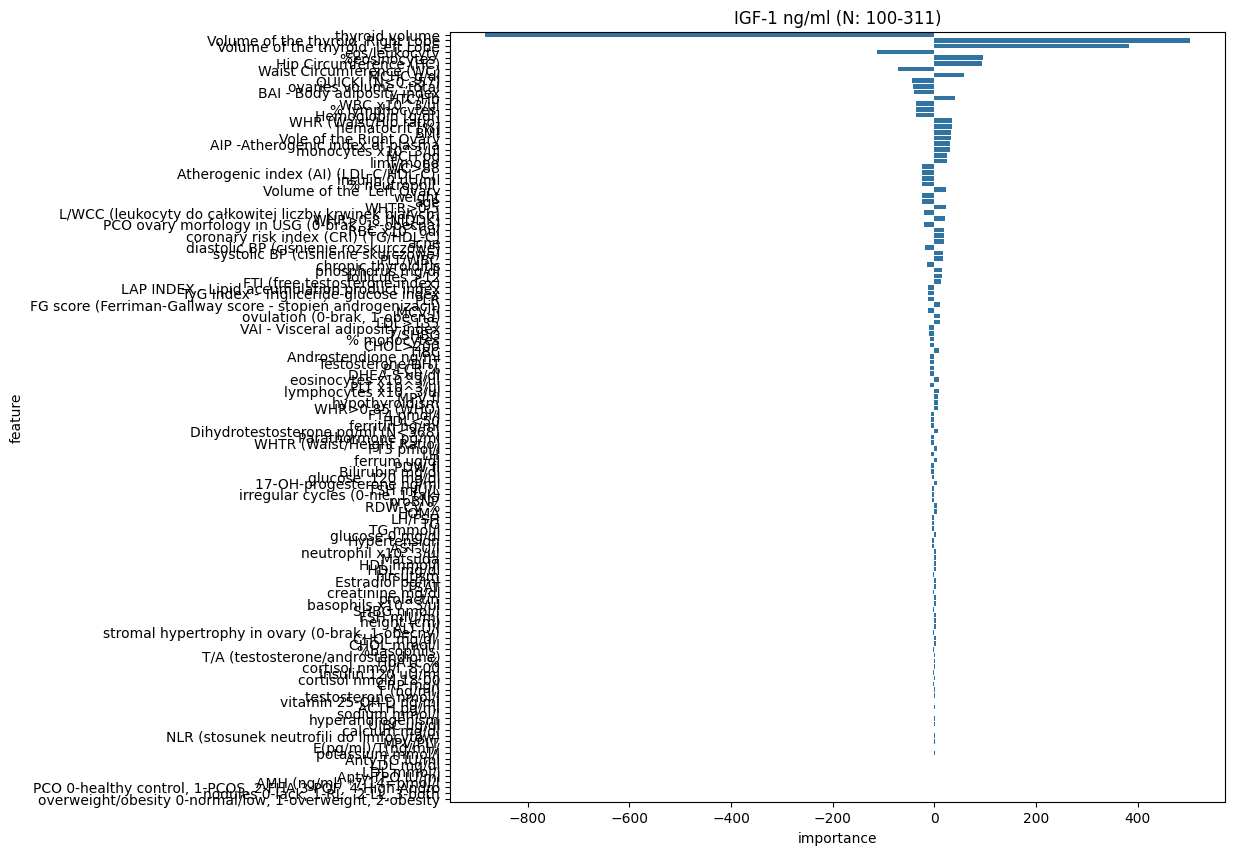

model  data_set        mse     mae     rmse     r2
0  LinearRegression()  training   2864.264  42.746   53.519  0.516
1  LinearRegression()      test  17644.244  70.916  132.832 -1.607

In [7]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


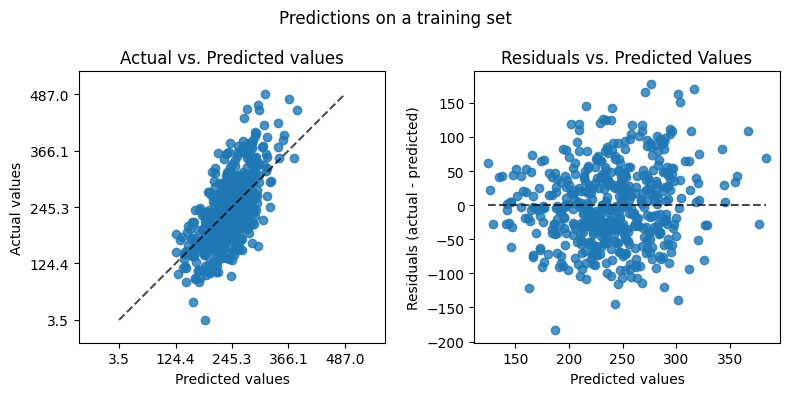

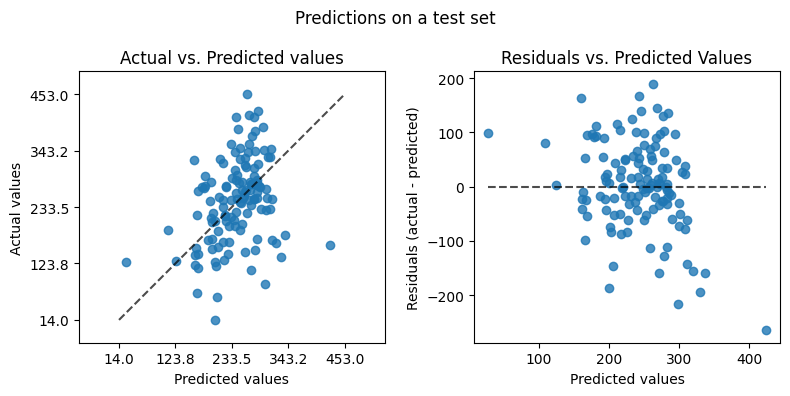

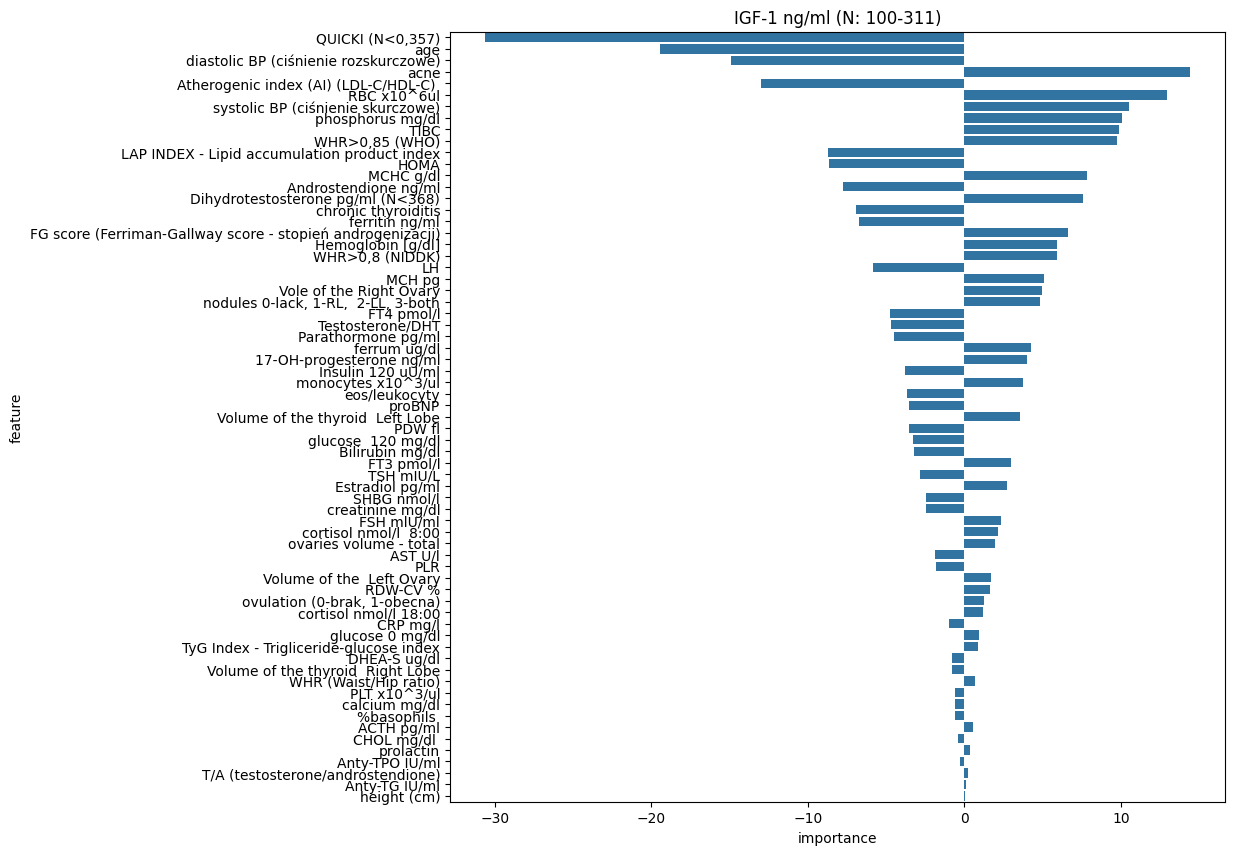

model  data_set       mse     mae    rmse     r2
0  Lasso(alpha=1)  training  3354.589  46.717  57.919  0.433
1  Lasso(alpha=1)      test  6676.362  61.961  81.709  0.014

In [8]:
lasso_model = Lasso(alpha=1)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


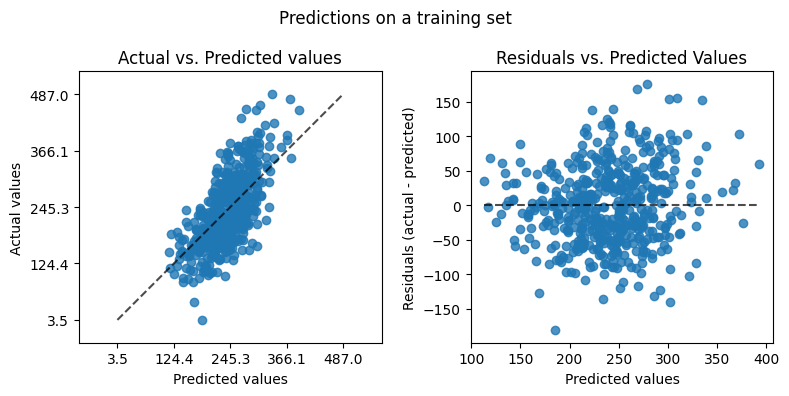

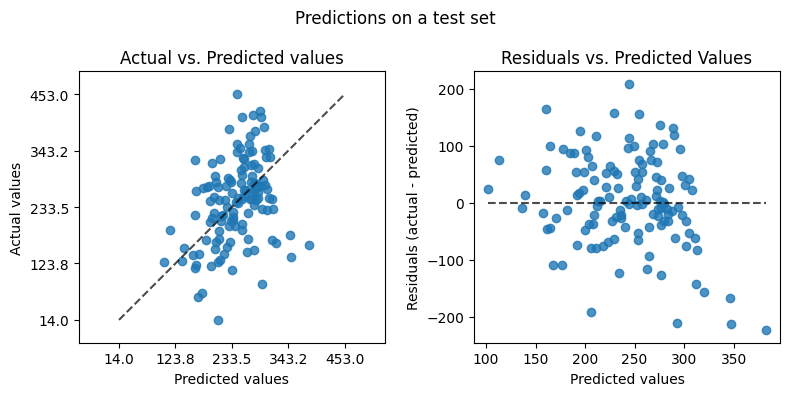

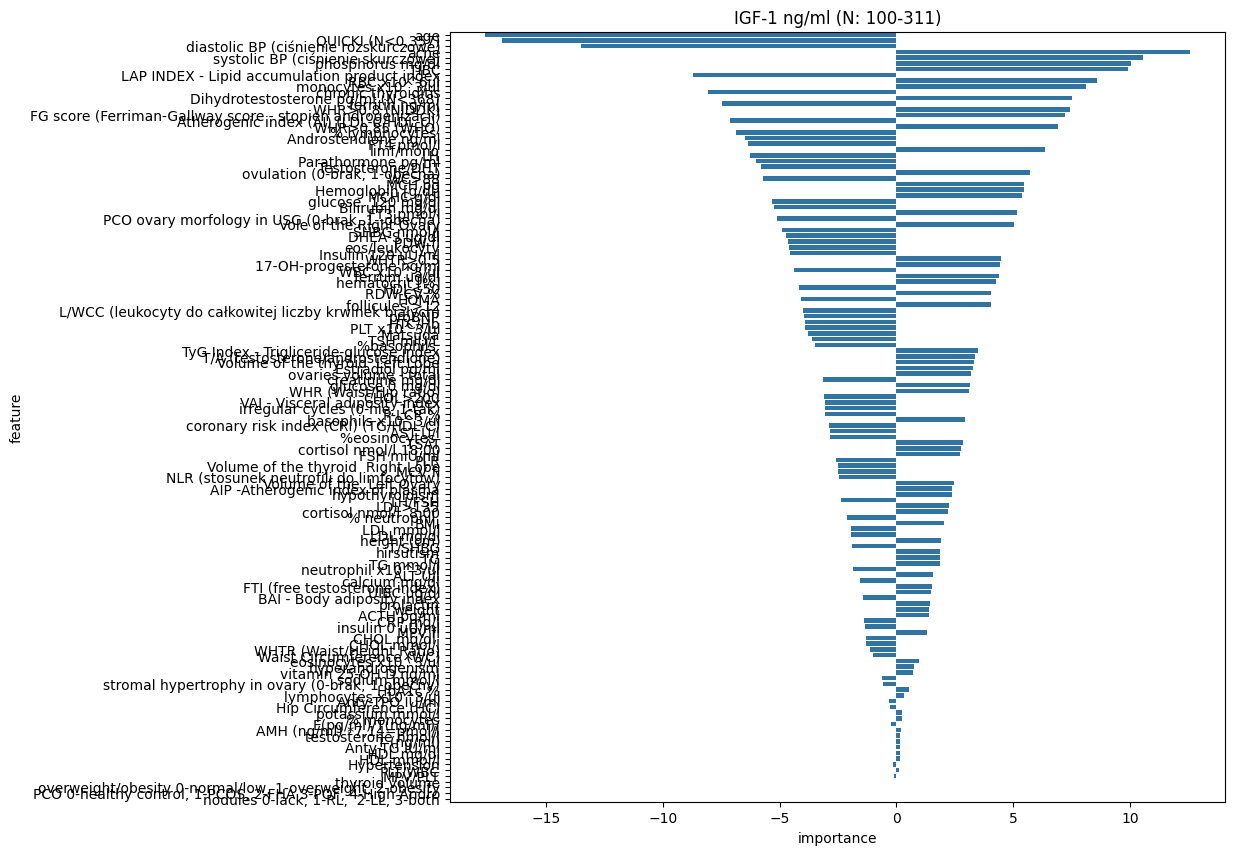

model  data_set       mse     mae    rmse     r2
0  Ridge(alpha=50)  training  3194.987  45.470  56.524  0.460
1  Ridge(alpha=50)      test  6395.880  61.348  79.974  0.055

In [9]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


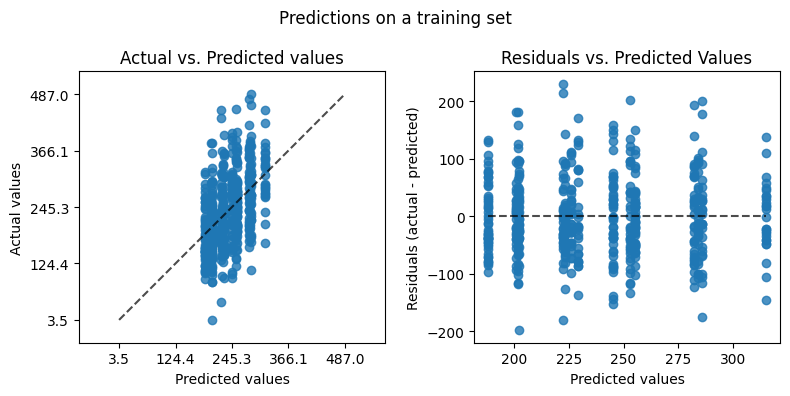

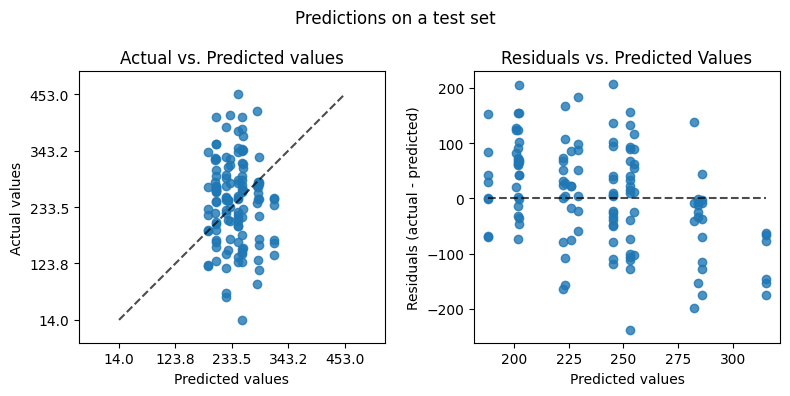

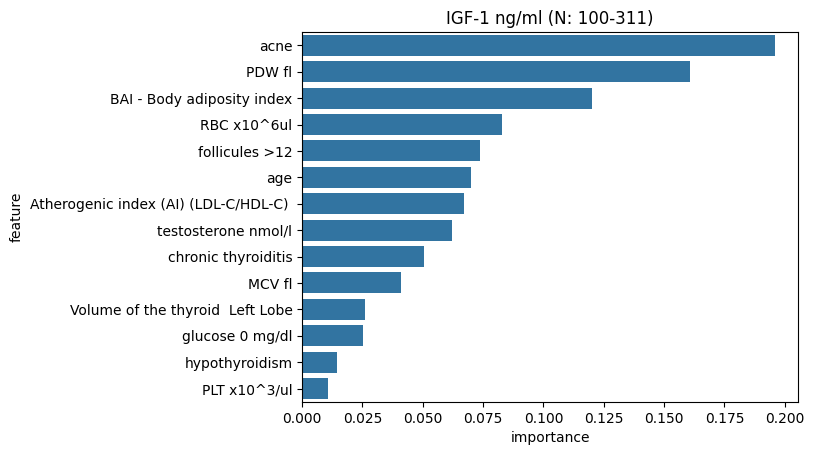

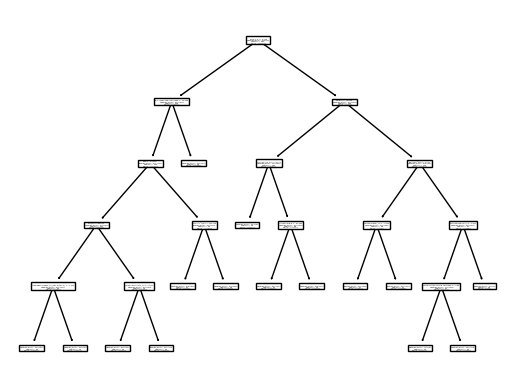

model  data_set       mse     mae    rmse     r2
0  DecisionTreeRegressor(max_depth=15, min_samples_leaf=25, min_samples_split=15,\n                      random_state=16, splitter='random')  training  4662.627  53.875  68.283  0.212
1  DecisionTreeRegressor(max_depth=15, min_samples_leaf=25, min_samples_split=15,\n                      random_state=16, splitter='random')      test  8219.034  72.604  90.659 -0.214

In [10]:
tree_model = DecisionTreeRegressor(criterion="squared_error", max_depth=15, min_samples_leaf=25, min_samples_split=15, splitter='random', random_state=16)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, tree_continuous_preprocessor, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


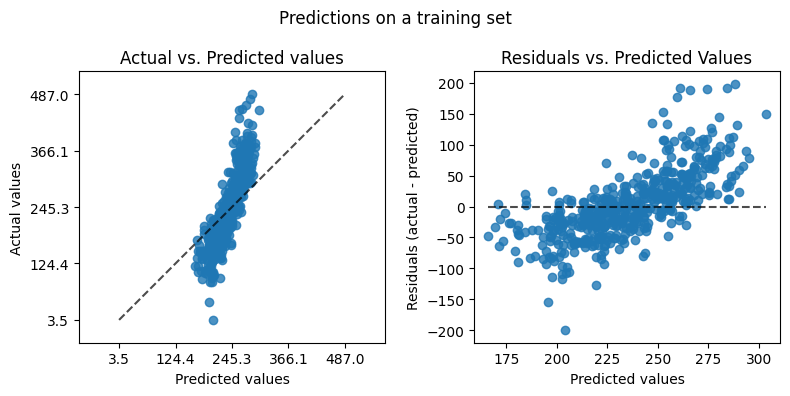

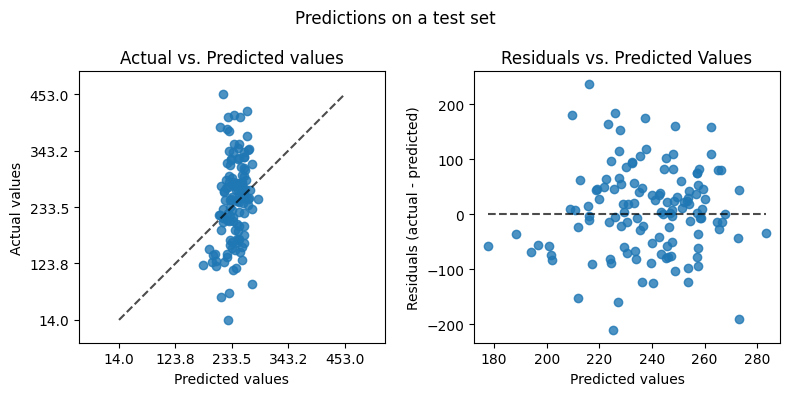

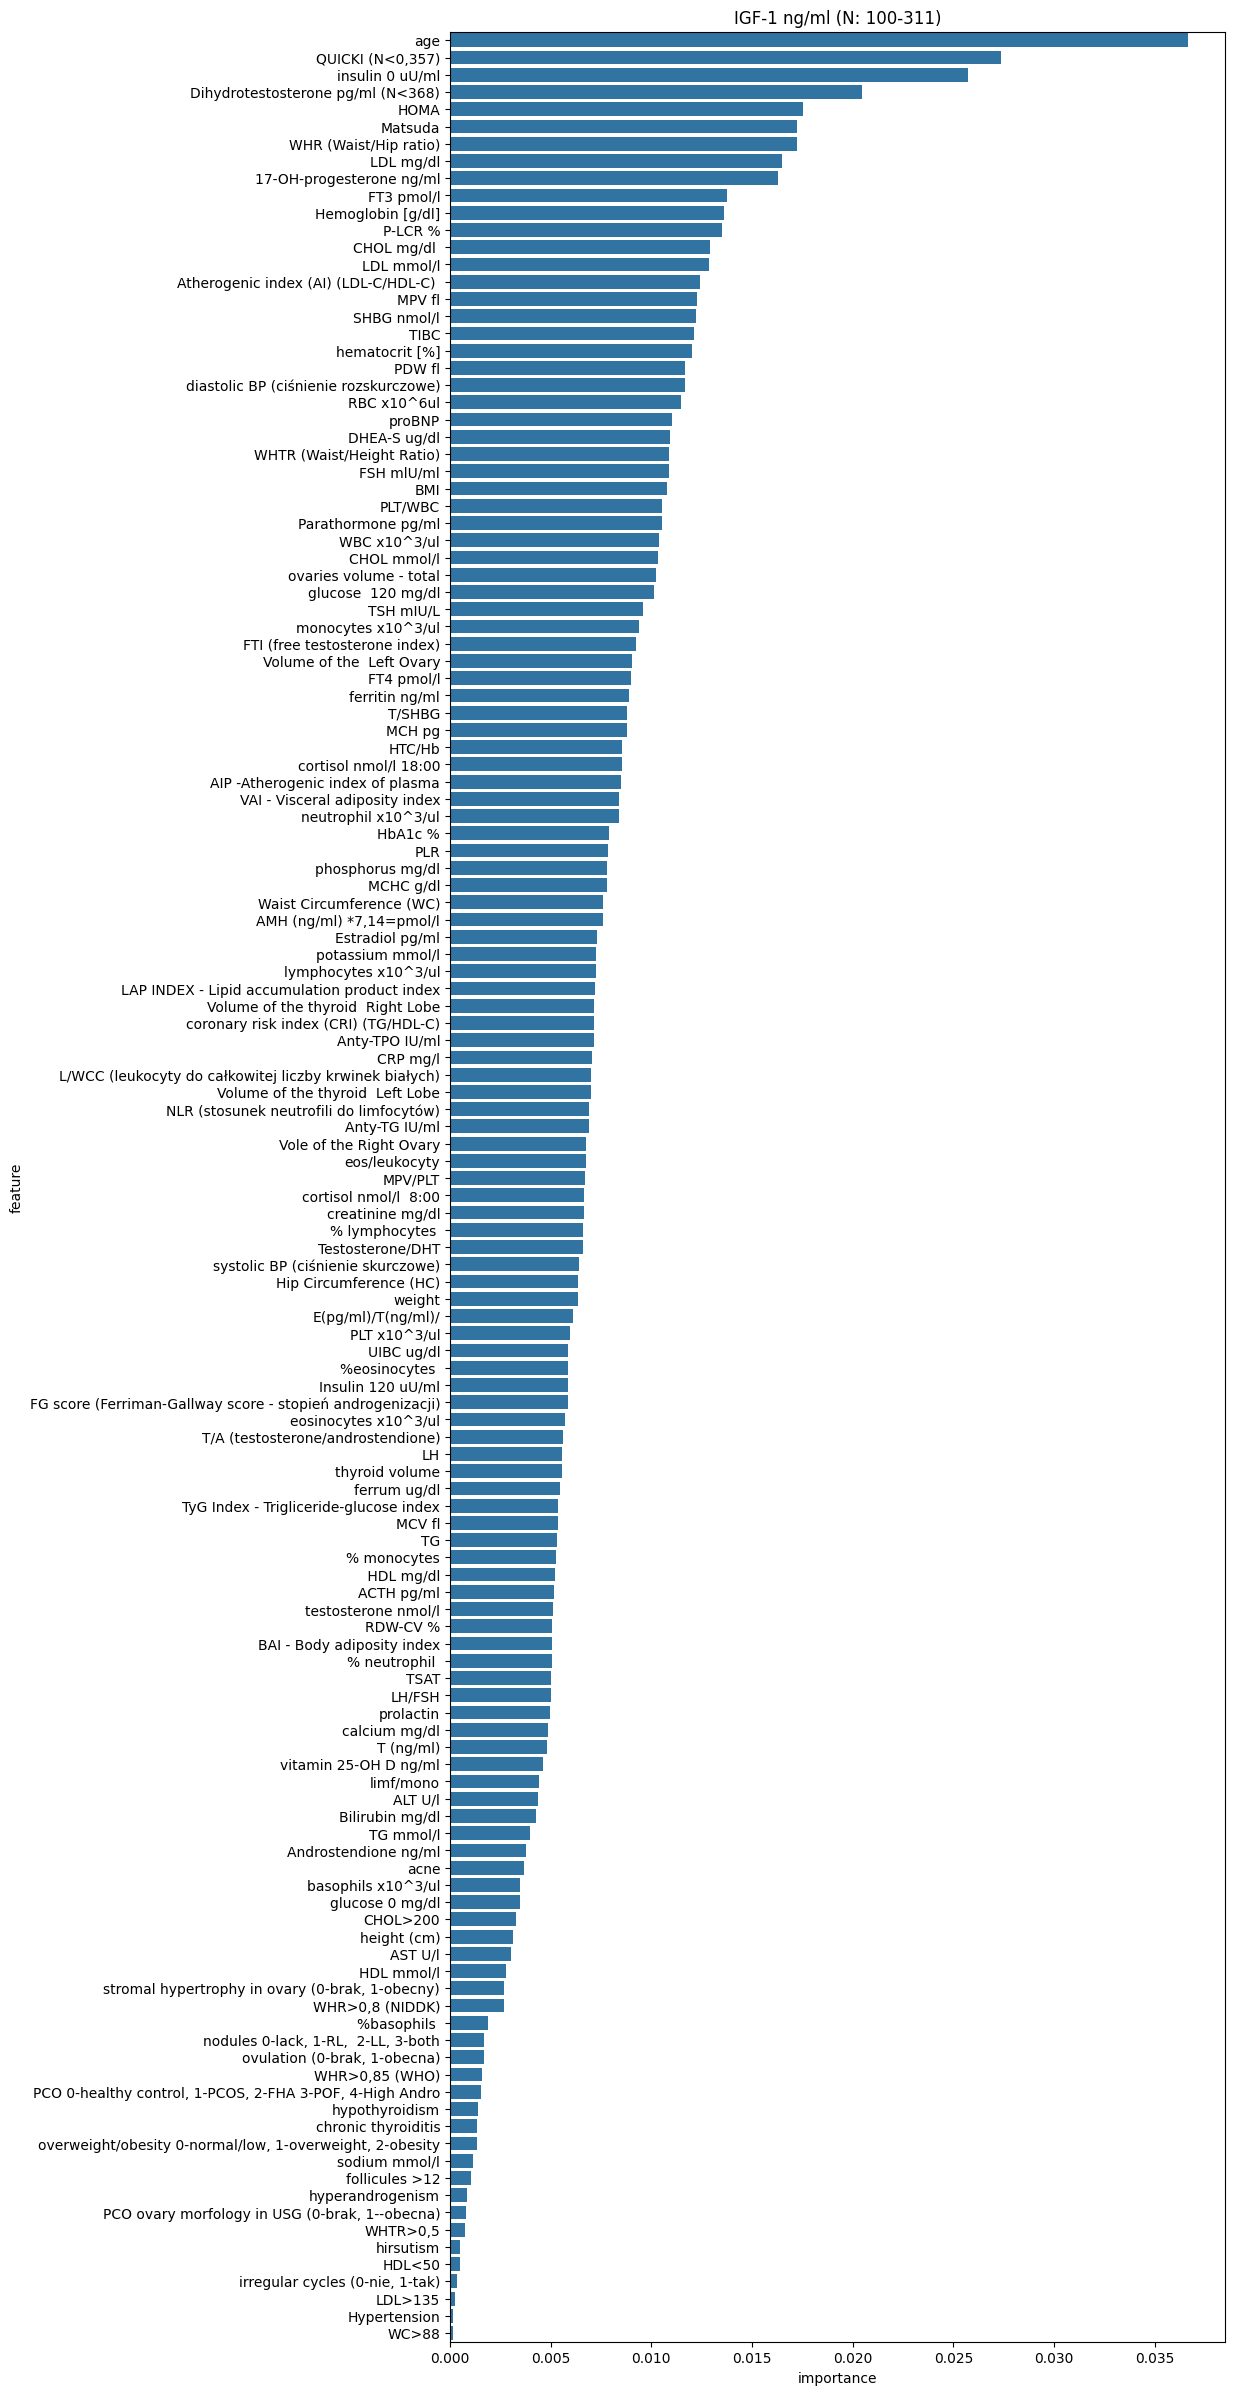

model  data_set       mse     mae    rmse     r2
0  RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n                      min_samples_leaf=7, min_samples_split=10,\n                      n_estimators=200, random_state=56)  training  3015.549  41.481  54.914  0.491
1  RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n                      min_samples_leaf=7, min_samples_split=10,\n                      n_estimators=200, random_state=56)      test  6320.412  61.932  79.501  0.066

In [11]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56)

vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, tree_continuous_preprocessor, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df

## Best models on subsets of data

In [8]:
index_features = [
    'LAP INDEX - Lipid accumulation product index',
    'VAI - Visceral adiposity index',
    'BAI - Body adiposity index',
    'TyG Index - Trigliceride-glucose index',
    'AIP -Atherogenic index of plasma',
    'Atherogenic index (AI) (LDL-C/HDL-C) ',
    'coronary risk index (CRI) (TG/HDL-C)',
    'FTI (free testosterone index)',
]



In [10]:
def difference_of_sets(set1, set2):
    return set(set1) - set(set2)

featureset_variations = {}

# without the obviously related features
# cropped_featureset = list(difference_of_sets(X_igf.columns, igf_associated_features))
# featureset_variations['cropped'] = cropped_featureset

#  inflammatory attributes
inflammatory_featureset = difference_of_sets(inflammatory_attributes, igf_associated_features)
featureset_variations['inflammatory'] = inflammatory_featureset

#  carbohydrate metabolism attributes
index_featureset = difference_of_sets(index_features, igf_associated_features)
featureset_variations['index'] = index_featureset

In [36]:
from sklearn.svm import SVR

# Definicja modelu SVR z jądrem rbf
svr_model = SVR(kernel='rbf')

# Definicja siatki parametrów
svr_param_grid = {
    'model__C': [0.1, 1, 10, 100],  # Parametr regularizacji
    'model__gamma': [0.001, 0.01, 0.1, 1],  # Współczynnik gamma w funkcji jądra rbf
    'model__epsilon': [0.01, 0.1, 0.2, 0.5]  # Szerokość rury epsilon
}

# Przeprowadzenie strojenia hiperparametrów
svr_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf[index_features], y_train_igf, IGF, svr_model, continuous_preprocessor, categorical_preprocessor, svr_param_grid)

# Sortowanie wyników według mean_test_score
svr_hyperparam_tuning_df.sort_values(by='mean_test_score').head()

Fitting 15 folds for each of 64 candidates, totalling 960 fits
Best parameters: {'model__C': 100, 'model__epsilon': 0.01, 'model__gamma': 0.01}
Best score (neg_mean_absolute_error): -59.33397776751567


params  mean_train_score  mean_test_score
49  {'model__C': 100, 'model__epsilon': 0.01, 'model__gamma': 0.01}         57.282535        59.333978
57   {'model__C': 100, 'model__epsilon': 0.2, 'model__gamma': 0.01}         57.286836        59.334714
53   {'model__C': 100, 'model__epsilon': 0.1, 'model__gamma': 0.01}         57.284886        59.335642
61   {'model__C': 100, 'model__epsilon': 0.5, 'model__gamma': 0.01}         57.289347        59.338370
38     {'model__C': 10, 'model__epsilon': 0.1, 'model__gamma': 0.1}         57.252487        59.689115

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best parameters: {'model__n_neighbors': 17}
Best score (neg_mean_absolute_error): -61.48581607843137


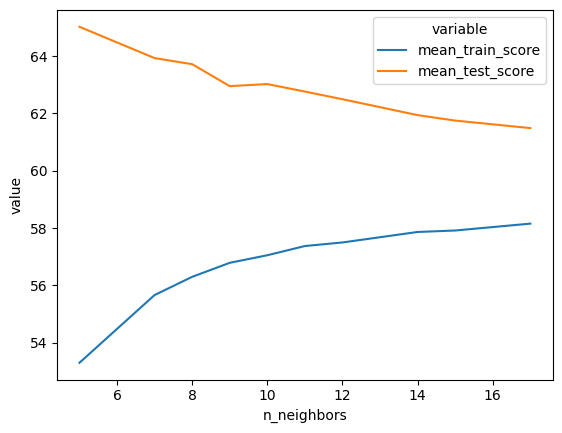

n_neighbors  mean_train_score  mean_test_score
9          17         58.154042        61.485816
8          15         57.914318        61.747008
7          14         57.863132        61.937536
6          12         57.497479        62.492472
5          11         57.372842        62.758587
3           9         56.787562        62.948547
4          10         57.051596        63.020849
2           8         56.298453        63.714253
1           7         55.664162        63.926015
0           5         53.301345        65.018391

In [38]:
knn_model = KNeighborsRegressor()

knn_param_grid = {
    'model__n_neighbors': [5, 7, 8, 9, 10, 11, 12, 14, 15, 17],  # Number of neighbors to consider
    # 'model__weights': ['uniform', 'distance'],  # Weight function used in prediction
    # 'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    # 'model__leaf_size': [20, 30, 40, 50],  # Leaf size passed to BallTree or KDTree
    # 'model__p': [1, 2]  # Power parameter for Minkowski metric (1 for Manhattan distance, 2 for Euclidean distance)
}

knn_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf[index_features], y_train_igf, IGF, knn_model, continuous_preprocessor, categorical_preprocessor, knn_param_grid, main_parameter='n_neighbors')
knn_hyperparam_tuning_df.sort_values(by='mean_test_score')

Featureset: inflammatory
Model: LinearRegression


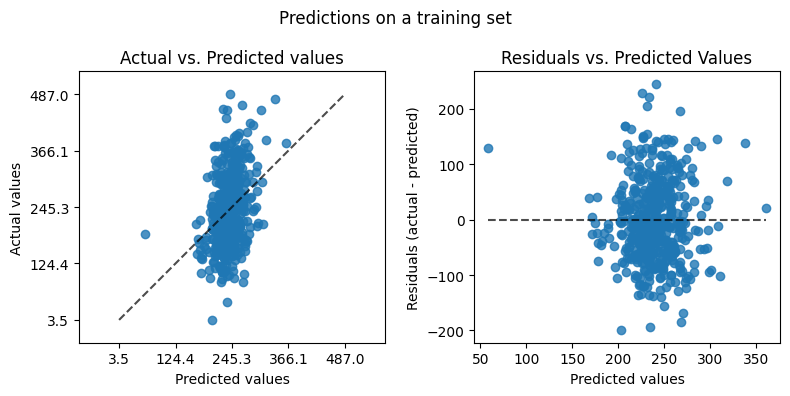

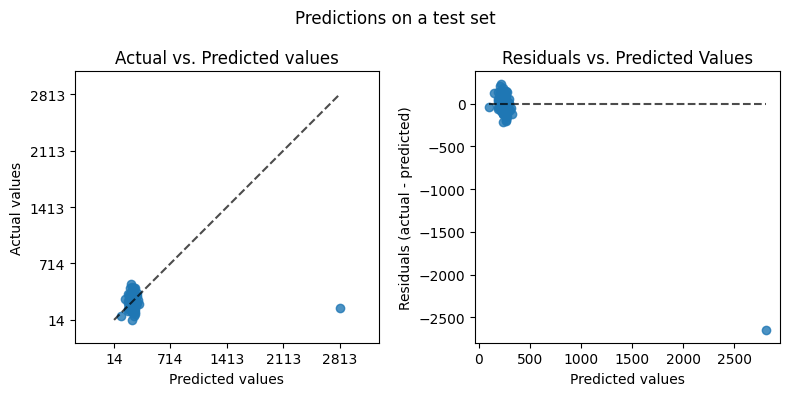

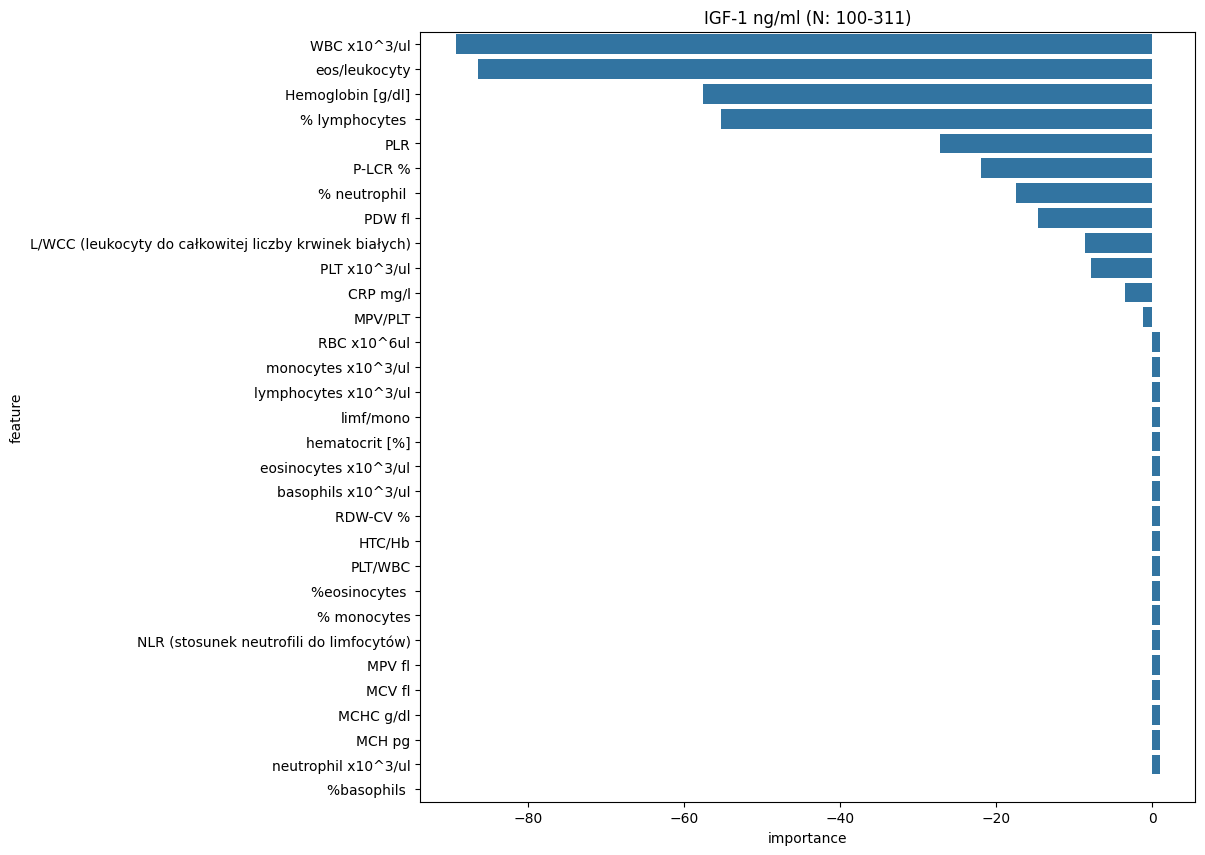

                model  data_set        mse     mae     rmse     r2
0  LinearRegression()  training   5247.873  57.907   72.442  0.113
1  LinearRegression()      test  62965.621  88.777  250.930 -8.303

Model: KNN


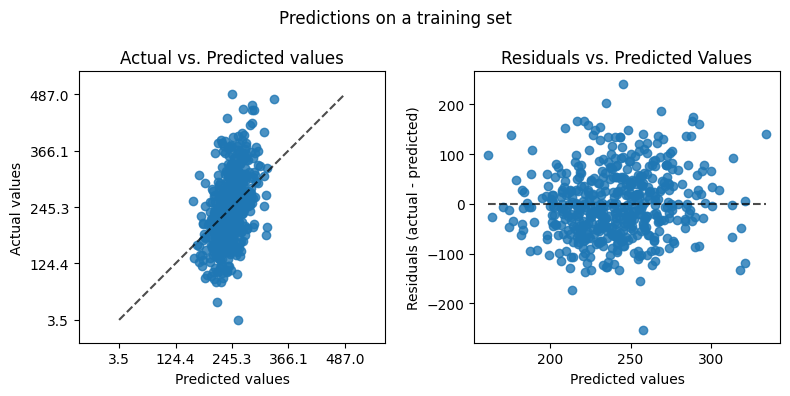

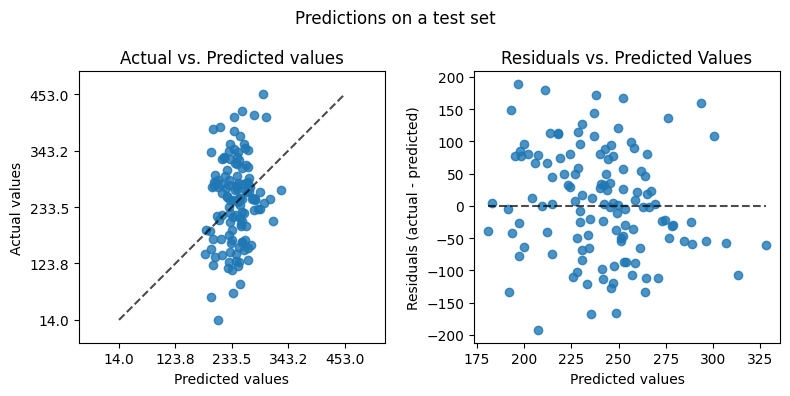

                                model  data_set       mse     mae    rmse     r2
0  KNeighborsRegressor(n_neighbors=9)  training  4640.520  53.848  68.121  0.216
1  KNeighborsRegressor(n_neighbors=9)      test  6807.277  67.502  82.506 -0.006

Model: SVR


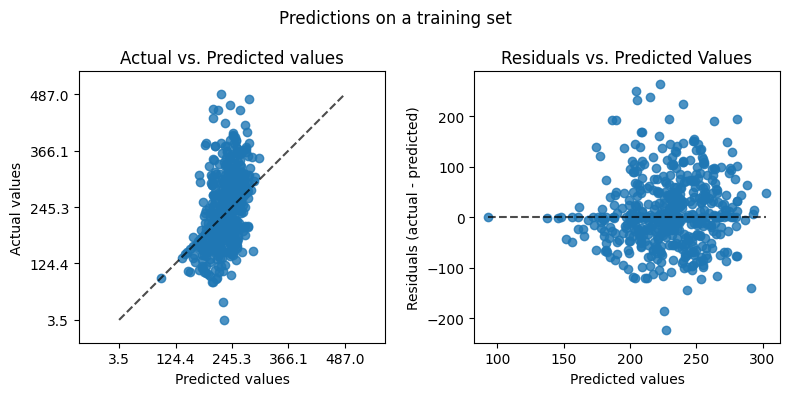

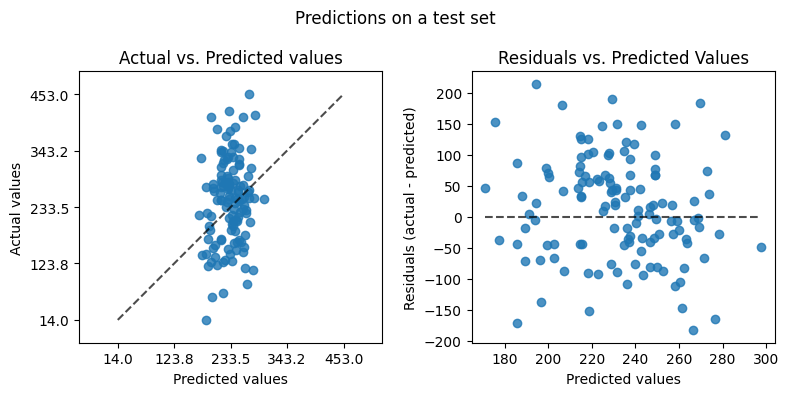

                                  model  data_set       mse     mae    rmse     r2
0  SVR(C=100, epsilon=0.01, gamma=0.01)  training  4854.753  51.014  69.676  0.180
1  SVR(C=100, epsilon=0.01, gamma=0.01)      test  6923.888  67.829  83.210 -0.023

Featureset: index
Model: LinearRegression


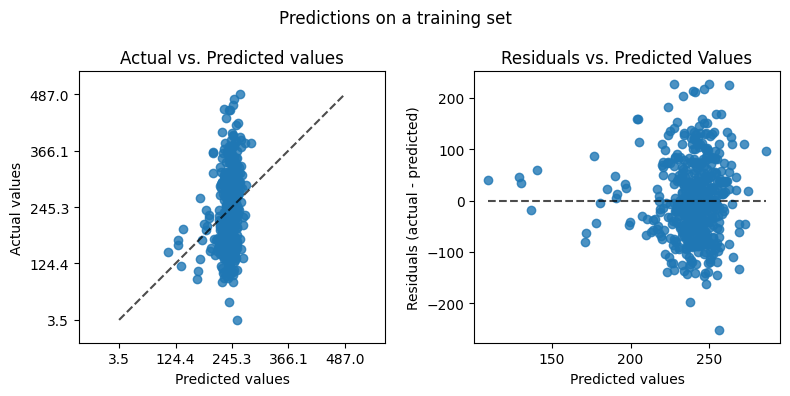

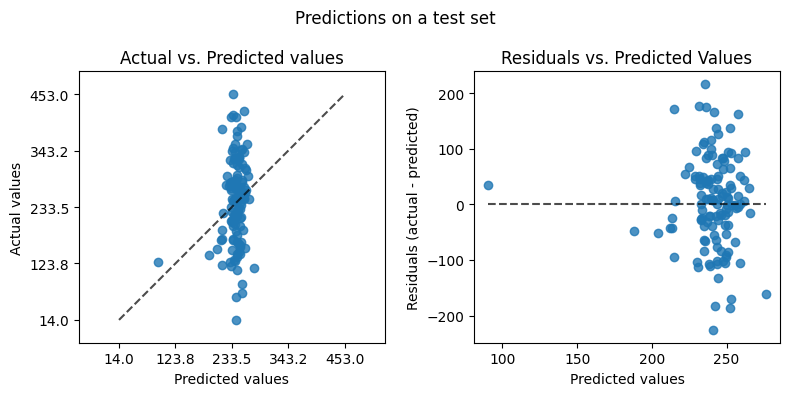

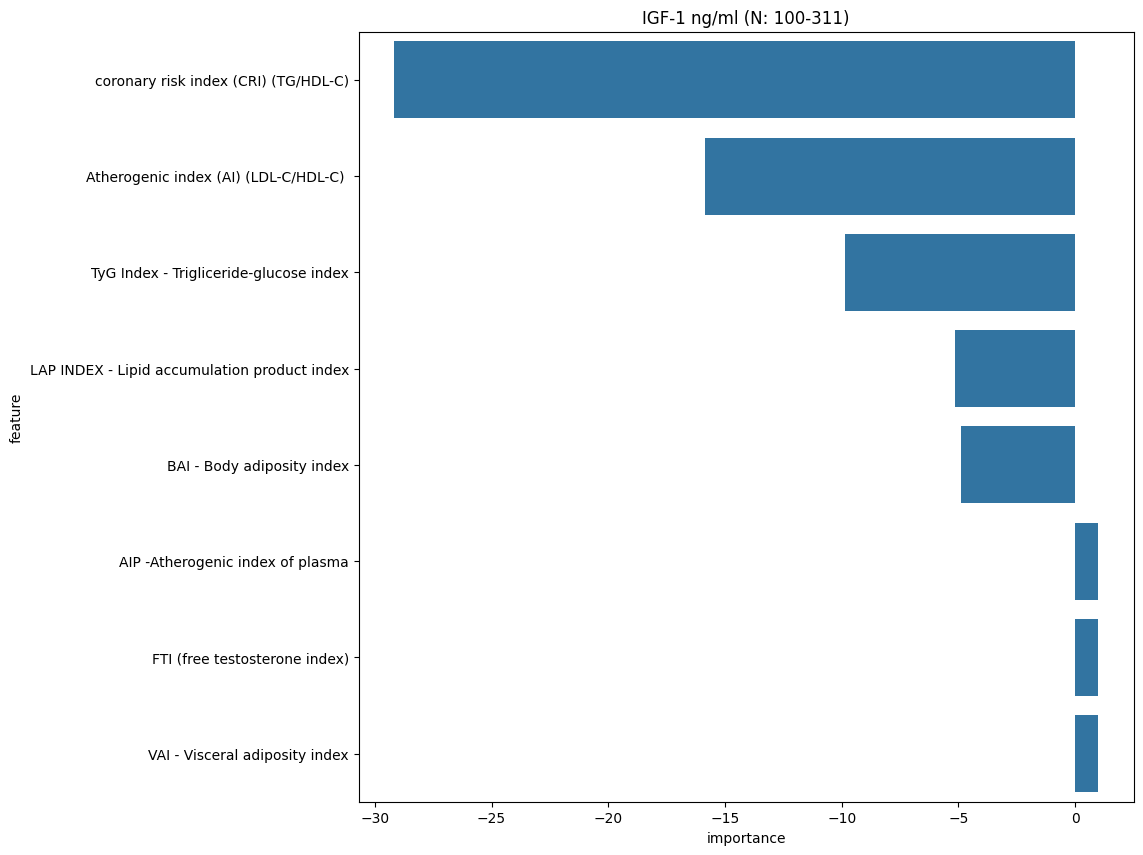

                model  data_set       mse     mae    rmse     r2
0  LinearRegression()  training  5585.475  59.573  74.736  0.056
1  LinearRegression()      test  6626.392  63.193  81.403  0.021

Model: KNN


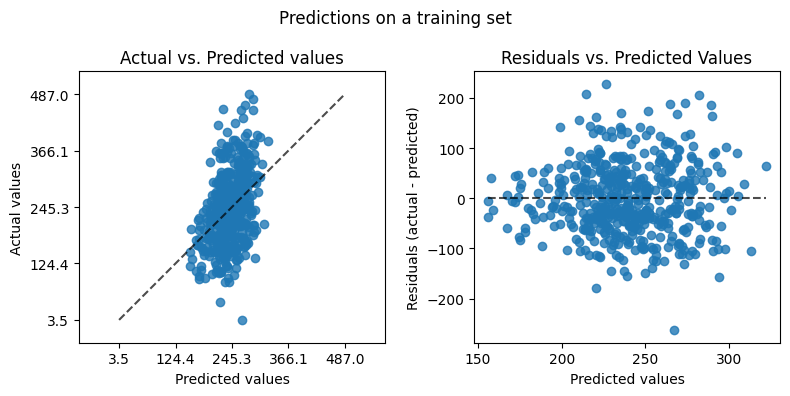

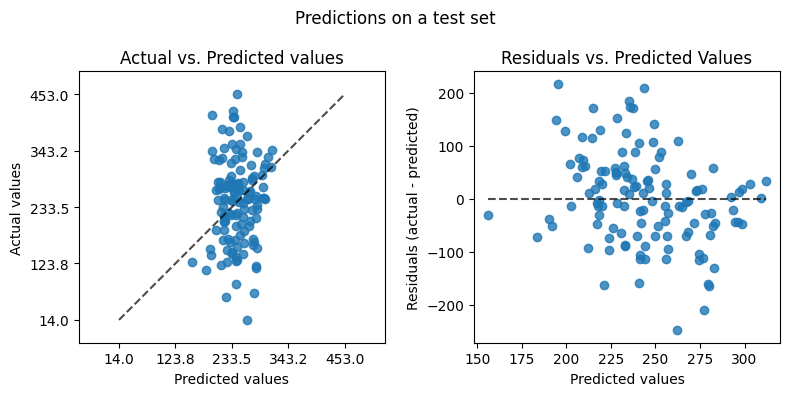

                                model  data_set       mse     mae    rmse     r2
0  KNeighborsRegressor(n_neighbors=9)  training  5022.035  57.034  70.866  0.152
1  KNeighborsRegressor(n_neighbors=9)      test  7362.287  66.992  85.804 -0.088

Model: SVR


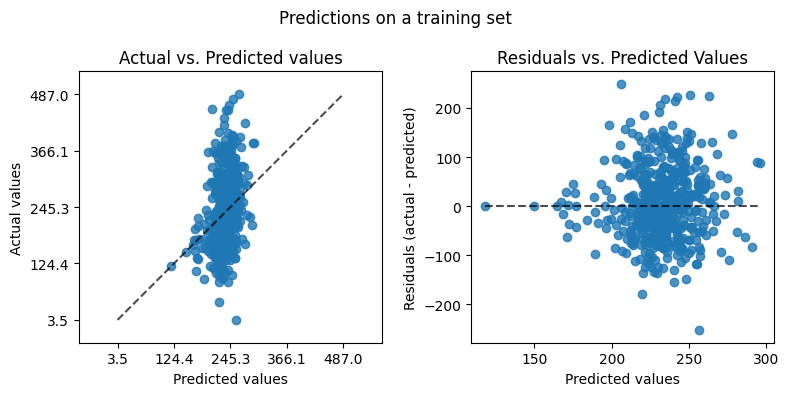

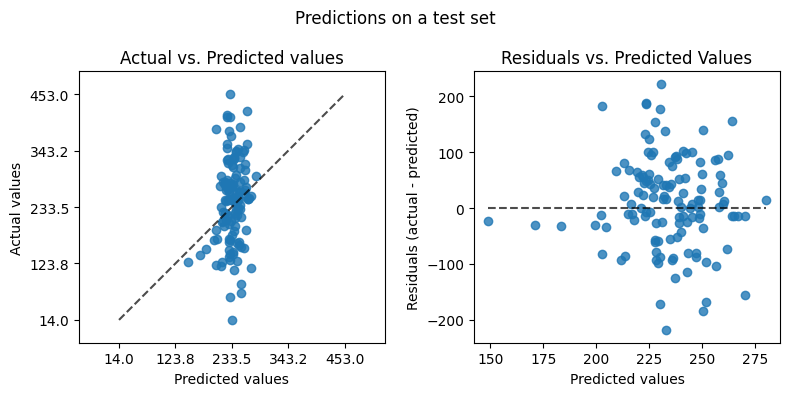

                                  model  data_set       mse     mae    rmse     r2
0  SVR(C=100, epsilon=0.01, gamma=0.01)  training  5432.683  57.417  73.707  0.082
1  SVR(C=100, epsilon=0.01, gamma=0.01)      test  6707.913  63.659  81.902  0.009



In [39]:



models = {
    'LinearRegression': (LinearRegression(), get_feature_importance_lasso, continuous_preprocessor),
    # 'Lasso': (Lasso(alpha=0.5), get_feature_importance_lasso, continuous_preprocessor),
    # 'Ridge': (Ridge(alpha=50), get_feature_importance_lasso, continuous_preprocessor),
    # 'DecisionTree': (DecisionTreeRegressor(criterion="absolute_error", max_depth=8, min_samples_leaf=27, min_samples_split=17, splitter='random', random_state=62), get_feature_importance_tree, tree_continuous_preprocessor),
    # 'RandomForest': (RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56), get_feature_importance_rf, tree_continuous_preprocessor),
    'KNN': (KNeighborsRegressor(n_neighbors=9), get_feature_importance_knn, continuous_preprocessor),
    'SVR': (SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.01), get_feature_importance_knn, continuous_preprocessor),
}


for featureset_name, featureset in featureset_variations.items():
    print(f"Featureset: {featureset_name}")
    X_featureset = X_igf[list(featureset)]
    X_train_featureset, X_test_featureset, y_train_featureset, y_test_featureset = train_test_split(X_featureset, y_igf, test_size=0.2, random_state=42)

    for model_name, (model, feature_importance_method, cont_preprocessor) in models.items():
        print(f"Model: {model_name}")
        model_scores_df, feature_importances = train_model(model, IGF, X_train_featureset, y_train_featureset, X_test_featureset, y_test_featureset, cont_preprocessor, categorical_preprocessor, feature_importance_method)
        print(model_scores_df)
        print()


Fitting 15 folds for each of 7 candidates, totalling 105 fits
Best parameters: {'model__alpha': 2}
Best score (neg_mean_absolute_error): -56.81756598275271


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


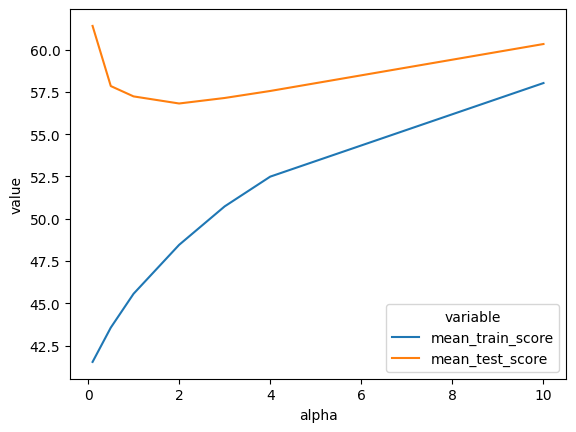

alpha  mean_train_score  mean_test_score
0   0.1         41.532339        61.405479
1   0.5         43.562395        57.848286
2     1         45.563867        57.236932
3     2         48.456127        56.817566
4     3         50.731411        57.143535
5     4         52.490764        57.557834
6    10         58.027013        60.334798

In [16]:
param_grid_lasso = {
    'model__alpha': [0.1, 0.5, 1, 2, 3, 4, 10],
}

lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf[cropped_featureset], y_train_igf, IGF, Lasso(), continuous_preprocessor, categorical_preprocessor, param_grid_lasso, main_parameter='alpha')
lasso_model_hyperparam_tuning_df

## Feature importances

In [40]:
selected_features_map = {}

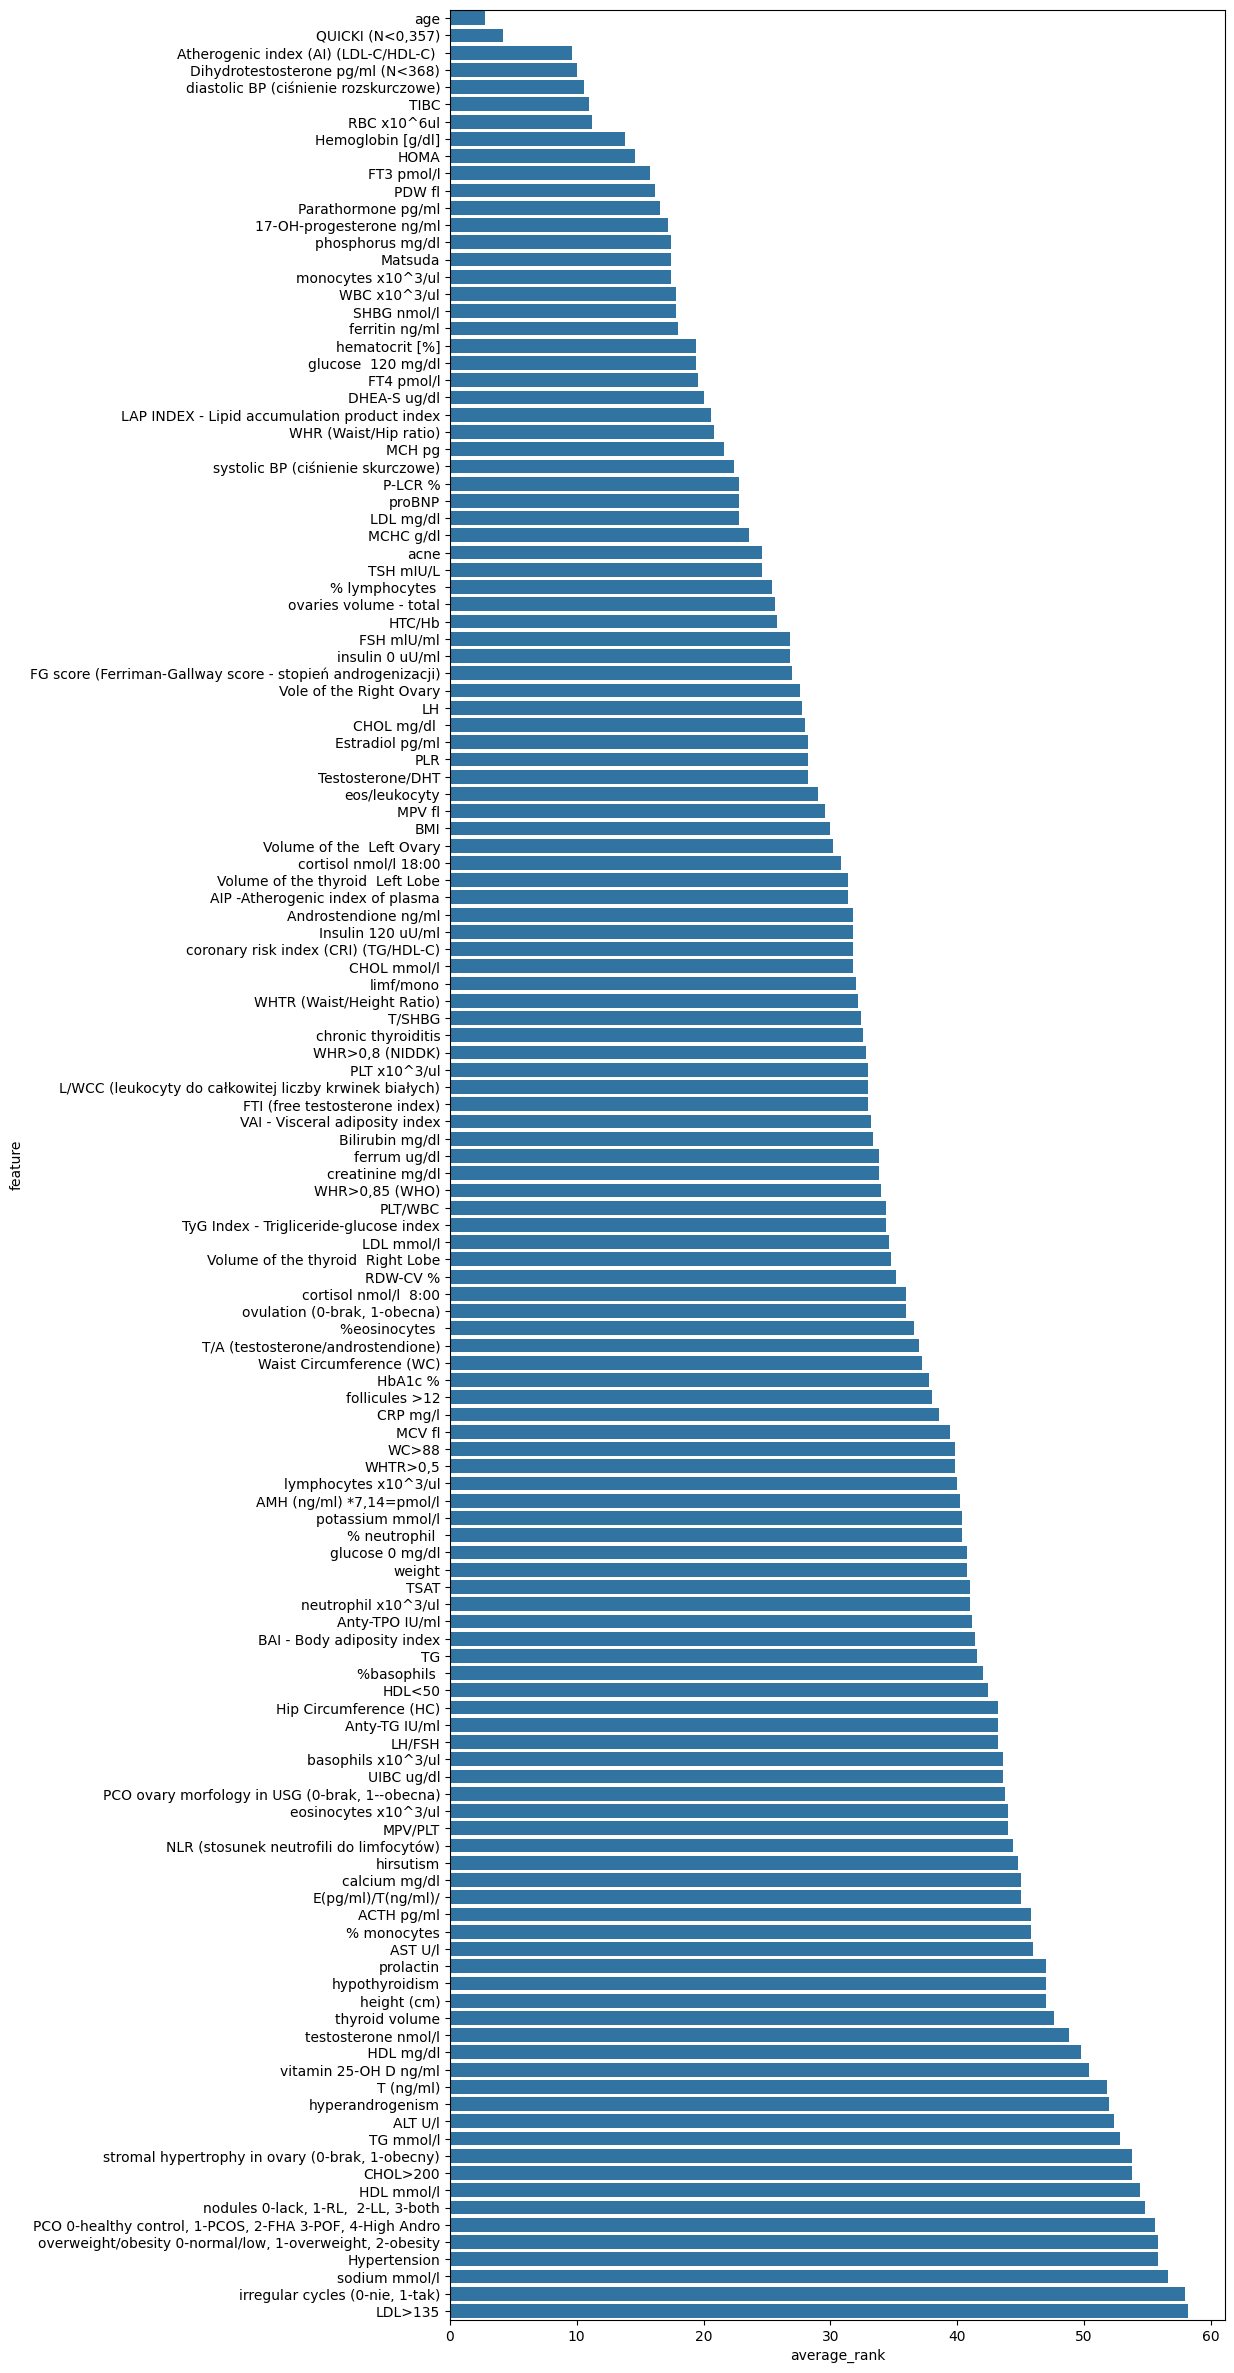

In [58]:
rename_importnace_col(feature_importnces_lr, 'linear_regression')
rename_importnace_col(feature_importnces_lasso, 'lasso')
rename_importnace_col(feature_importnces_ridge, 'ridge')
rename_importnace_col(feature_importnces_tree, 'tree')
rename_importnace_col(feature_importnces_rf, 'rf')

feature_importance_df = merge_feature_importances([feature_importnces_lr, feature_importnces_lasso, feature_importnces_ridge, feature_importnces_tree, feature_importnces_rf])

ranked_df = rank_importances(feature_importance_df)
ranked_df_sorted = ranked_df.sort_values(by='average_rank')

plt.figure(figsize=(10, 30))
sns.barplot(ranked_df_sorted, x="average_rank", y="feature")
plt.show()

In [59]:
overall_rank_top_features = ranked_df_sorted[ranked_df_sorted['average_rank'] < 30] # a cut found on the plot above
overall_rank_selected_features = list(overall_rank_top_features['feature'].values)

selected_features_map['average_rank'] = overall_rank_selected_features
print(f'Top {len(overall_rank_selected_features)} features:')
overall_rank_selected_features

Top 47 features:


['age',
 'QUICKI (N<0,357)',
 'Atherogenic index (AI) (LDL-C/HDL-C) ',
 'Dihydrotestosterone pg/ml (N<368)',
 'diastolic BP (ciśnienie rozskurczowe)',
 'TIBC',
 'RBC x10^6ul',
 'Hemoglobin [g/dl]',
 'HOMA',
 'FT3 pmol/l',
 'PDW fl',
 'Parathormone pg/ml',
 '17-OH-progesterone ng/ml',
 'phosphorus mg/dl',
 'Matsuda',
 'monocytes x10^3/ul',
 'WBC x10^3/ul',
 'SHBG nmol/l',
 'ferritin ng/ml',
 'hematocrit [%]',
 'glucose  120 mg/dl',
 'FT4 pmol/l',
 'DHEA-S ug/dl',
 'LAP INDEX - Lipid accumulation product index',
 'WHR (Waist/Hip ratio)',
 'MCH pg',
 'systolic BP (ciśnienie skurczowe)',
 'P-LCR %',
 'proBNP',
 'LDL mg/dl',
 'MCHC g/dl',
 'acne',
 'TSH mIU/L',
 '% lymphocytes ',
 'ovaries volume - total',
 'HTC/Hb',
 'FSH mlU/ml',
 'insulin 0 uU/ml',
 'FG score (Ferriman-Gallway score - stopień androgenizacji)',
 'Vole of the Right Ovary',
 'LH',
 'CHOL mg/dl ',
 'Estradiol pg/ml',
 'PLR',
 'Testosterone/DHT',
 'eos/leukocyty',
 'MPV fl']

## Feature selection methods

### Mutual info

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


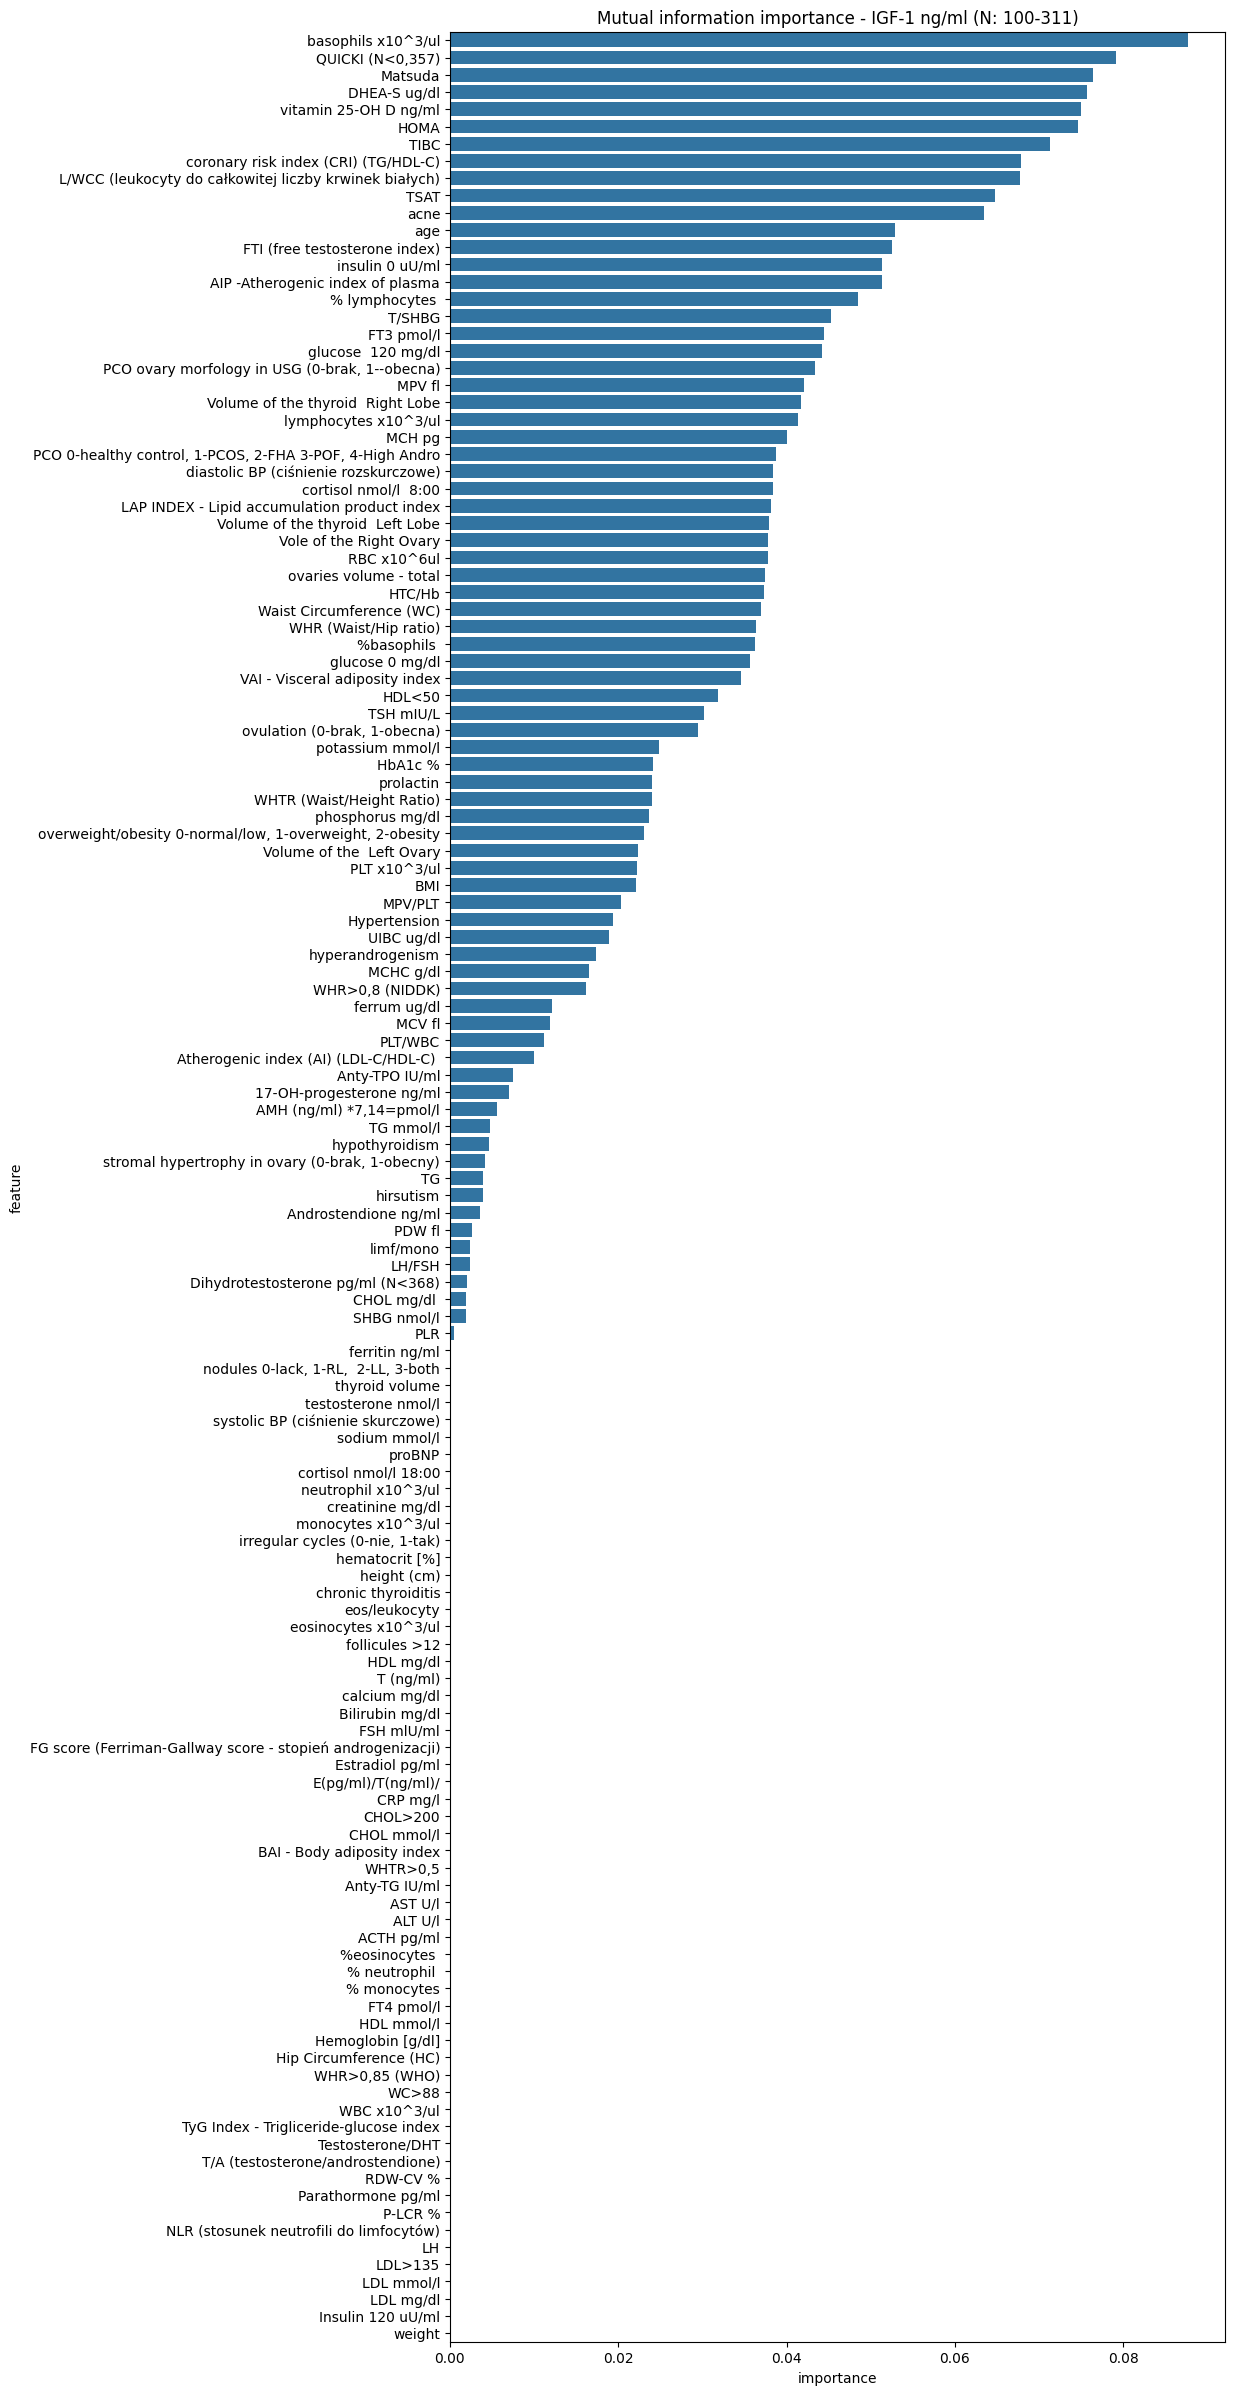

Selected 76 features


In [25]:
selected_feature_names_mutual_info = feature_selection_mutual_info_regression(X_train_igf, y_train_igf, IGF, continuous_preprocessor, categorical_preprocessor)
selected_feature_names_mutual_info = selected_feature_names_mutual_info[selected_feature_names_mutual_info['importance'] > 0]

selected_feature_names_mutual_info.reset_index(drop=True, inplace=True)
print(f'Selected {len(selected_feature_names_mutual_info)} features')
selected_features_map['mutual_info'] = list(selected_feature_names_mutual_info['feature'].values)
# selected_feature_names_mutual_info

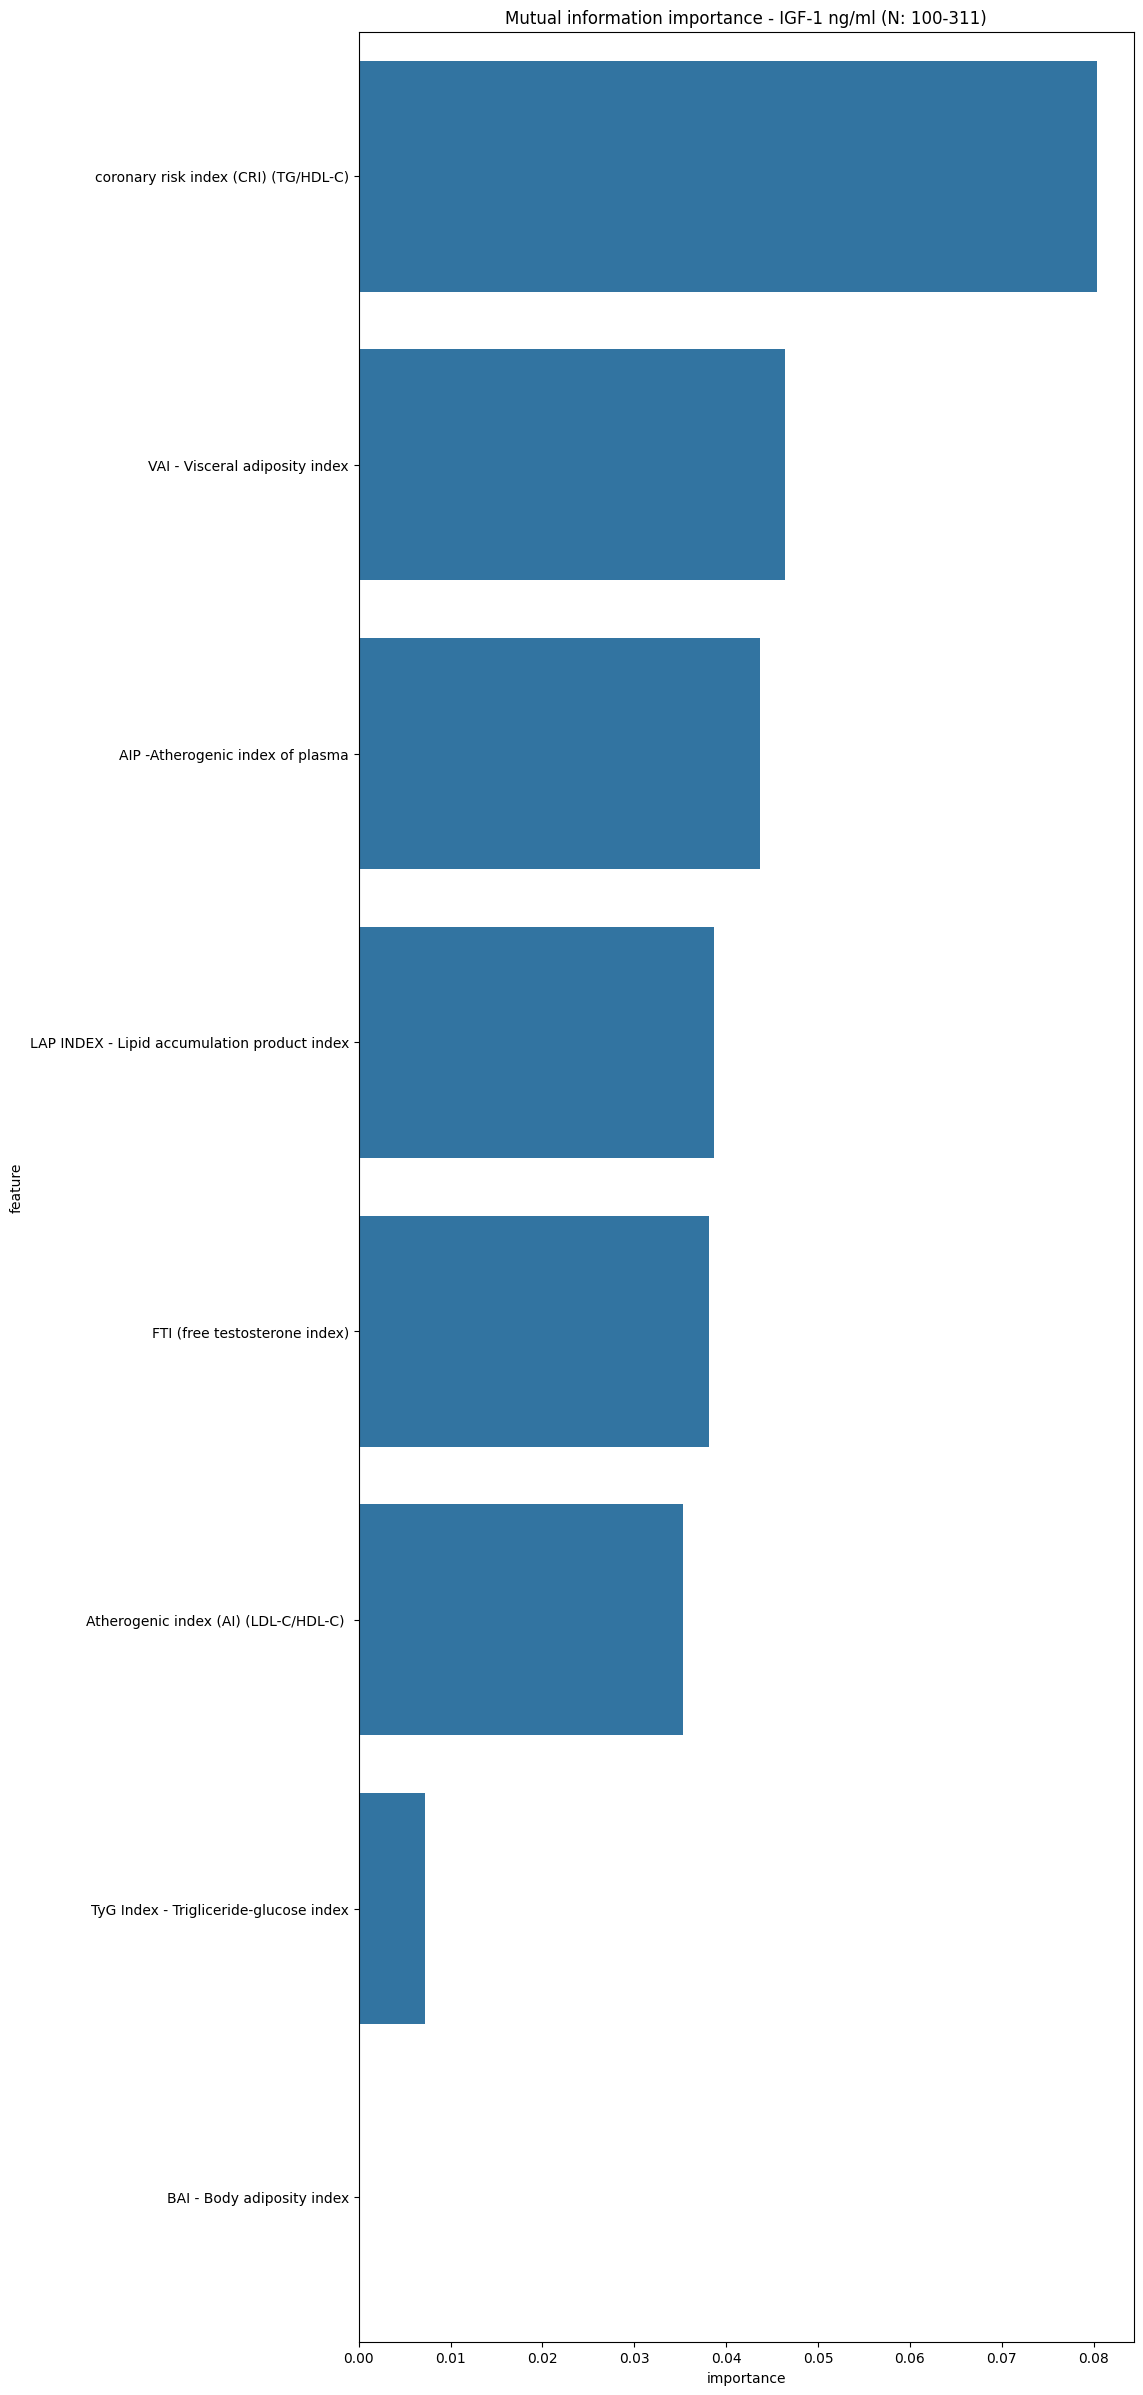

Selected 7 features


In [41]:
selected_feature_names_mutual_info = feature_selection_mutual_info_regression(X_train_igf[index_features], y_train_igf, IGF, continuous_preprocessor, categorical_preprocessor)
selected_feature_names_mutual_info = selected_feature_names_mutual_info[selected_feature_names_mutual_info['importance'] > 0]

selected_feature_names_mutual_info.reset_index(drop=True, inplace=True)
print(f'Selected {len(selected_feature_names_mutual_info)} features')
selected_features_map['mutual_info'] = list(selected_feature_names_mutual_info['feature'].values)
# selected_feature_names_mutual_info

### Recursive feature elimination

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Optimal number of features: 23


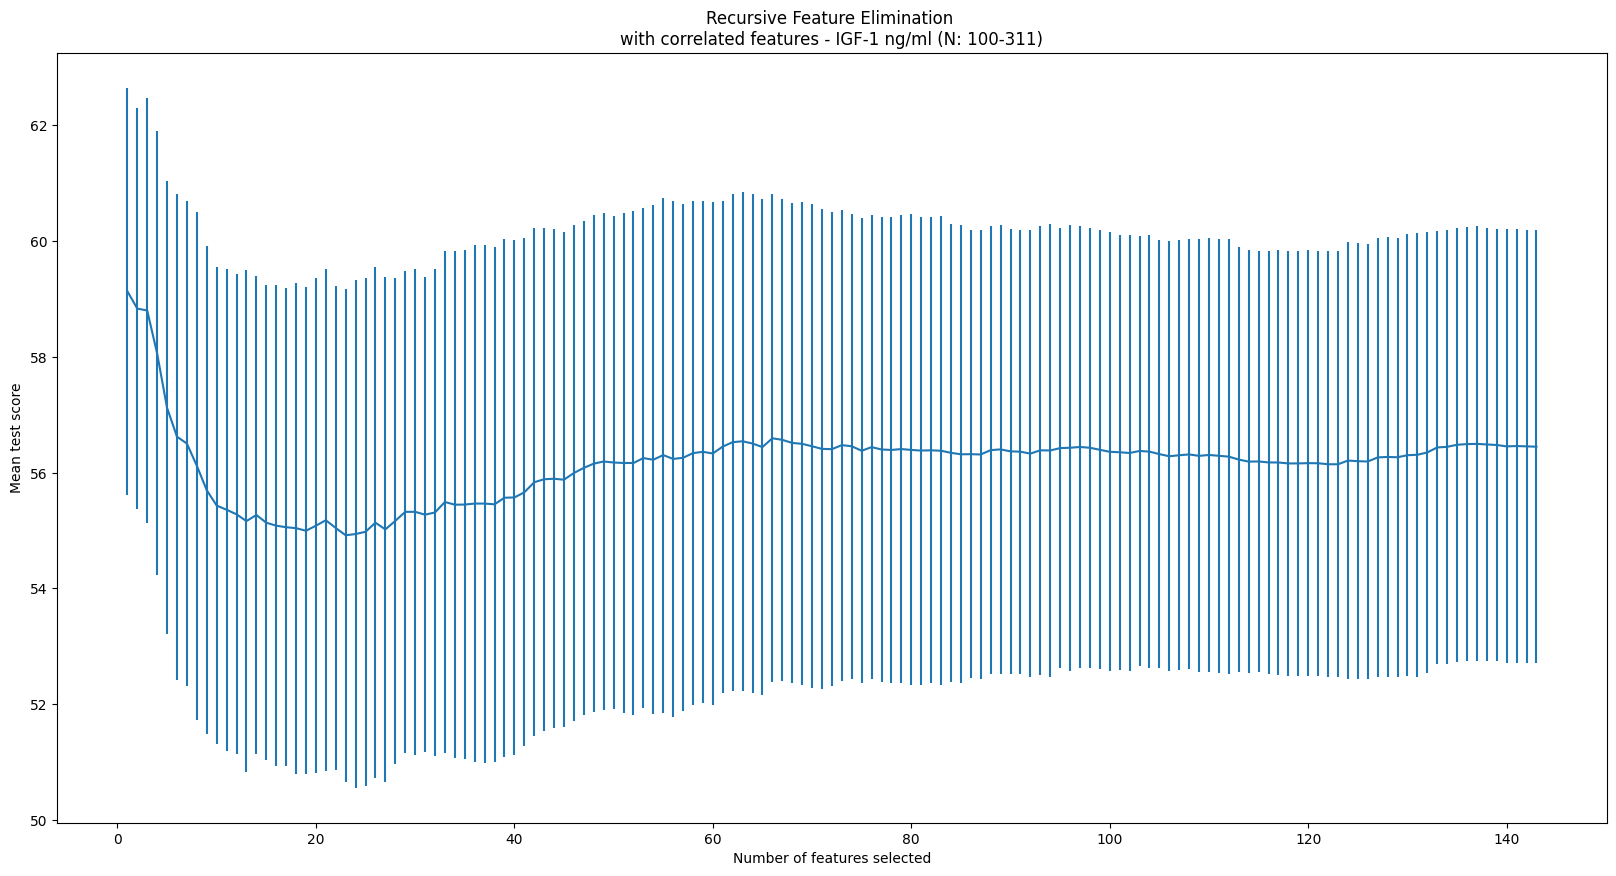

['LAP INDEX - Lipid accumulation product index',
 'QUICKI (N<0,357)',
 'Dihydrotestosterone pg/ml (N<368)',
 'RBC x10^6ul',
 'TIBC',
 'MCH pg',
 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity',
 'WHR>0,8 (NIDDK)',
 'Atherogenic index (AI) (LDL-C/HDL-C) ',
 'FG score (Ferriman-Gallway score - stopień androgenizacji)',
 'glucose  120 mg/dl',
 'Androstendione ng/ml',
 'phosphorus mg/dl',
 'acne',
 'age',
 'chronic thyroiditis',
 'diastolic BP (ciśnienie rozskurczowe)',
 'ferritin ng/ml',
 'nodules 0-lack, 1-RL,  2-LL, 3-both',
 'systolic BP (ciśnienie skurczowe)',
 'Hemoglobin [g/dl]',
 'WHR>0,85 (WHO)',
 'Parathormone pg/ml']

In [73]:
# lasso_model = Lasso(alpha=1)
lasso_model = Ridge(alpha=50)

recursive_feature_elimination_ranked_features_lasso = recursive_feature_elimination(X_train_igf, y_train_igf, lasso_model, IGF, continuous_preprocessor, categorical_preprocessor)
selected_features_map['recursive_feature_elimination'] = list(recursive_feature_elimination_ranked_features_lasso[recursive_feature_elimination_ranked_features_lasso['ranking'] == 1]['feature'].values)
selected_features_map['recursive_feature_elimination']

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Optimal number of features: 12


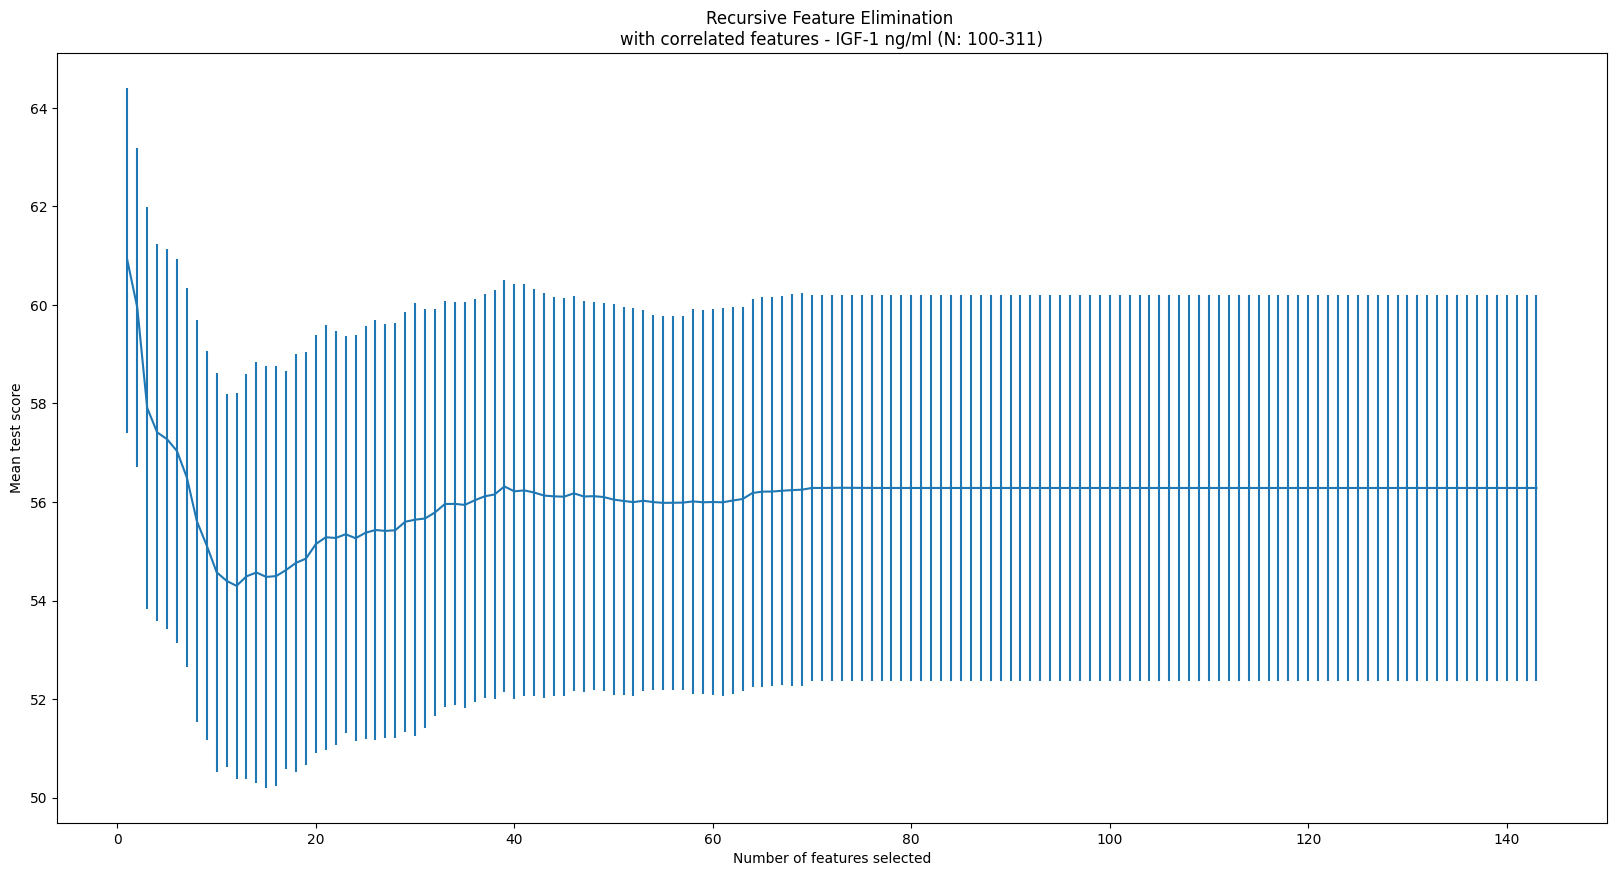

['TIBC',
 'chronic thyroiditis',
 'age',
 'acne',
 'HOMA',
 'Atherogenic index (AI) (LDL-C/HDL-C) ',
 'diastolic BP (ciśnienie rozskurczowe)',
 'phosphorus mg/dl',
 'WHR>0,85 (WHO)',
 'Hemoglobin [g/dl]',
 'systolic BP (ciśnienie skurczowe)',
 'QUICKI (N<0,357)']

In [61]:
lasso_model = Lasso(alpha=1)
# lasso_model = Ridge(alpha=50)

recursive_feature_elimination_ranked_features_lasso = recursive_feature_elimination(X_train_igf, y_train_igf, lasso_model, IGF, continuous_preprocessor, categorical_preprocessor)
selected_features_map['recursive_feature_elimination'] = list(recursive_feature_elimination_ranked_features_lasso[recursive_feature_elimination_ranked_features_lasso['ranking'] == 1]['feature'].values)
selected_features_map['recursive_feature_elimination']

### Permutation importance

selected 8 features


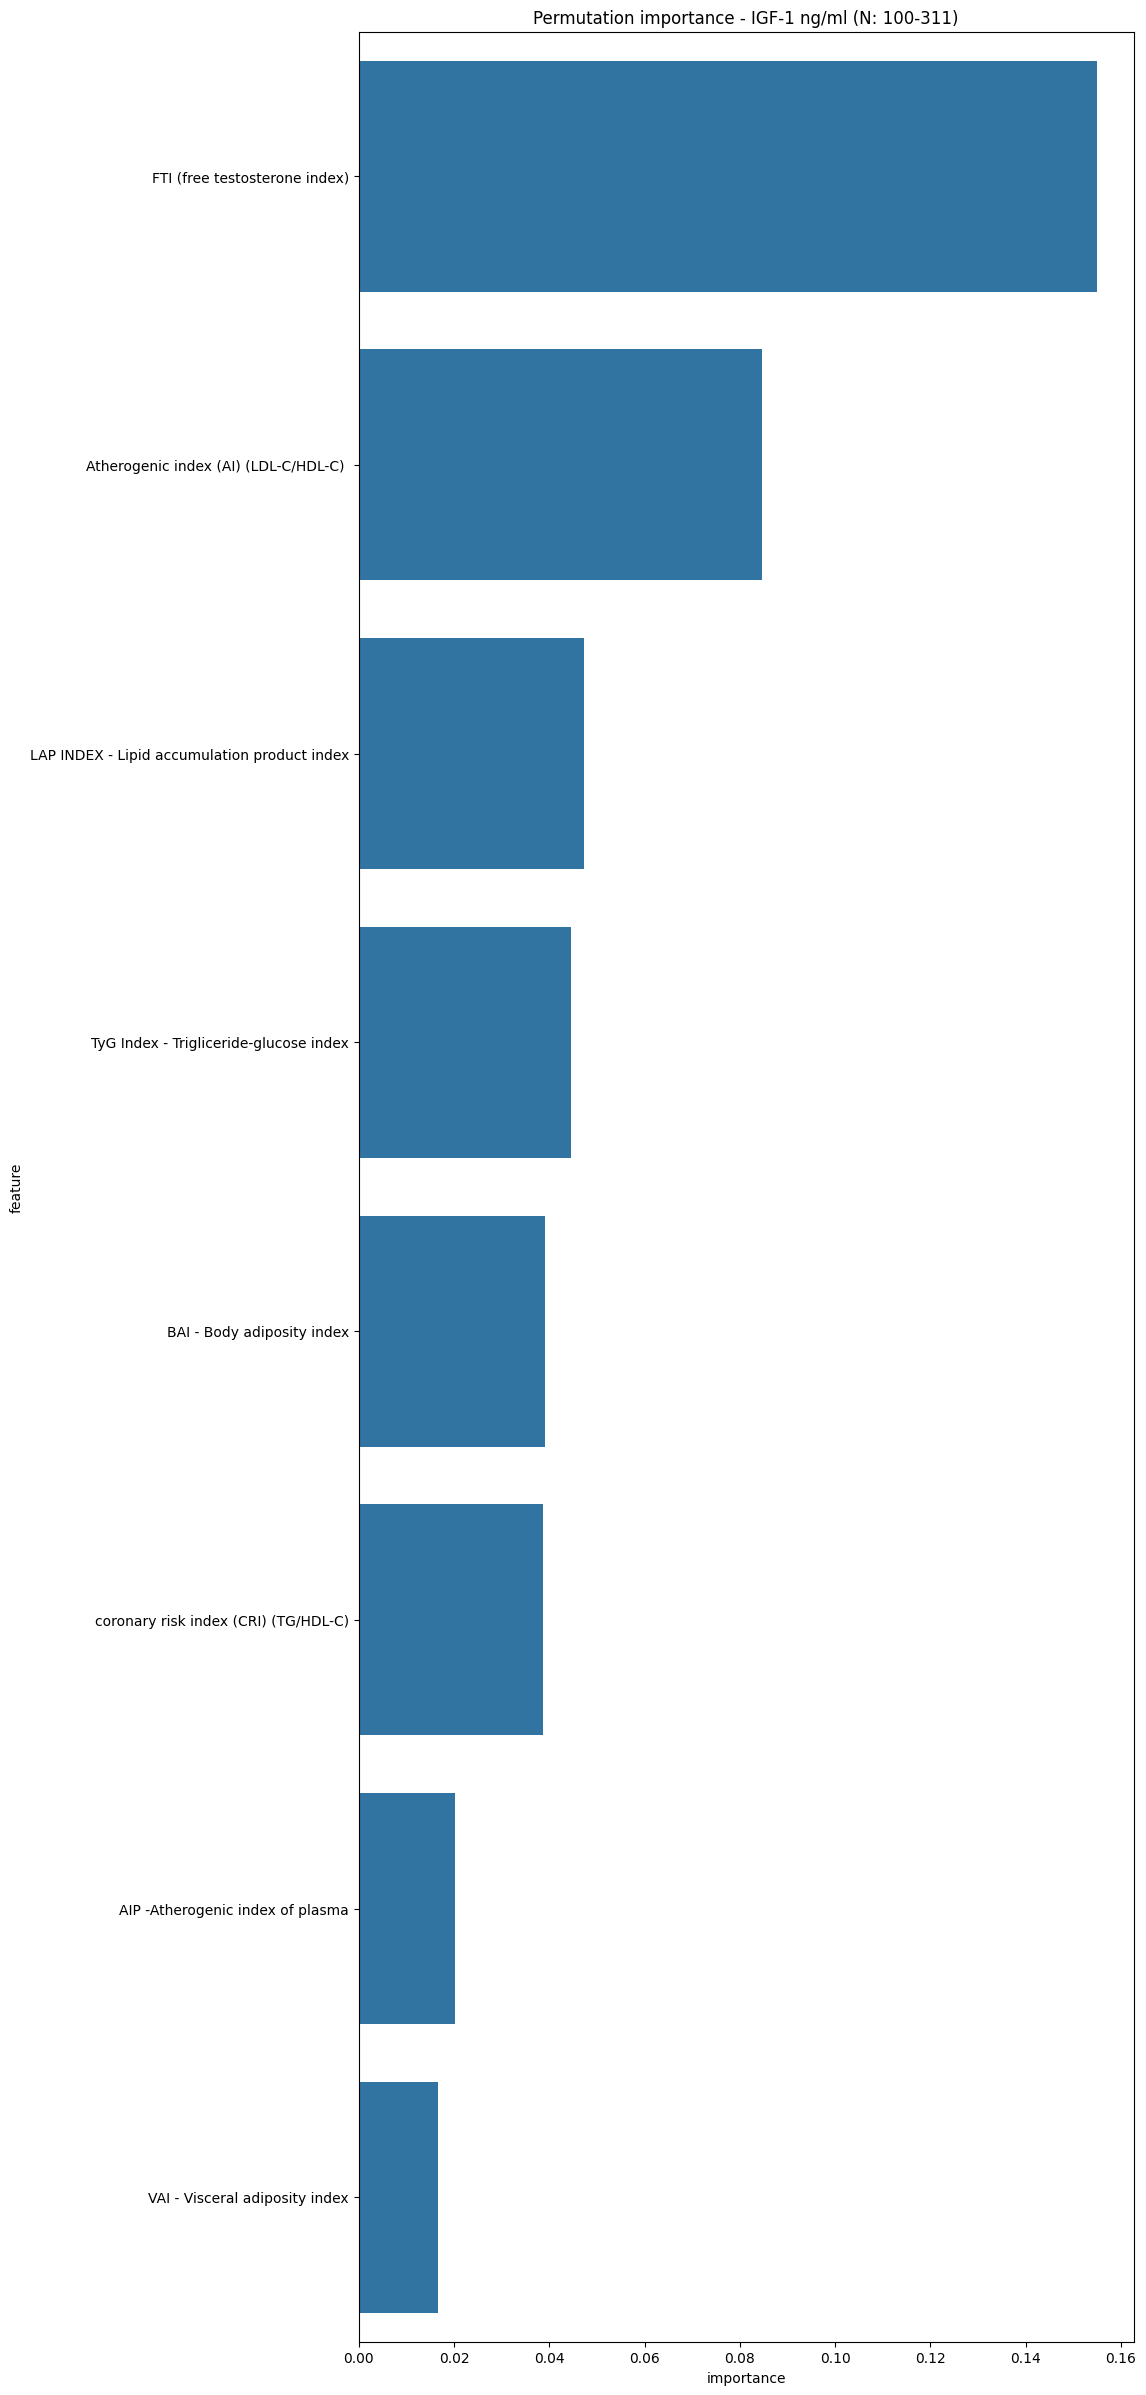

Actually selected 8 features


In [42]:
# lasso_model = Lasso(alpha=1)
knn_model = KNeighborsRegressor(n_neighbors=9)

selected_features_permutation_importance = get_permutation_importance(X_train_igf[index_features], y_train_igf, knn_model, continuous_preprocessor, categorical_preprocessor, IGF)
selected_features_permutation_importance = selected_features_permutation_importance[selected_features_permutation_importance['importance'] > 0.0001]
selected_features_map['permutation_importance'] = list(selected_features_permutation_importance['feature'].values)
print(f'Actually selected {len(selected_features_map['permutation_importance'])} features')
# selected_features_permutation_importance

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


selected 77 features


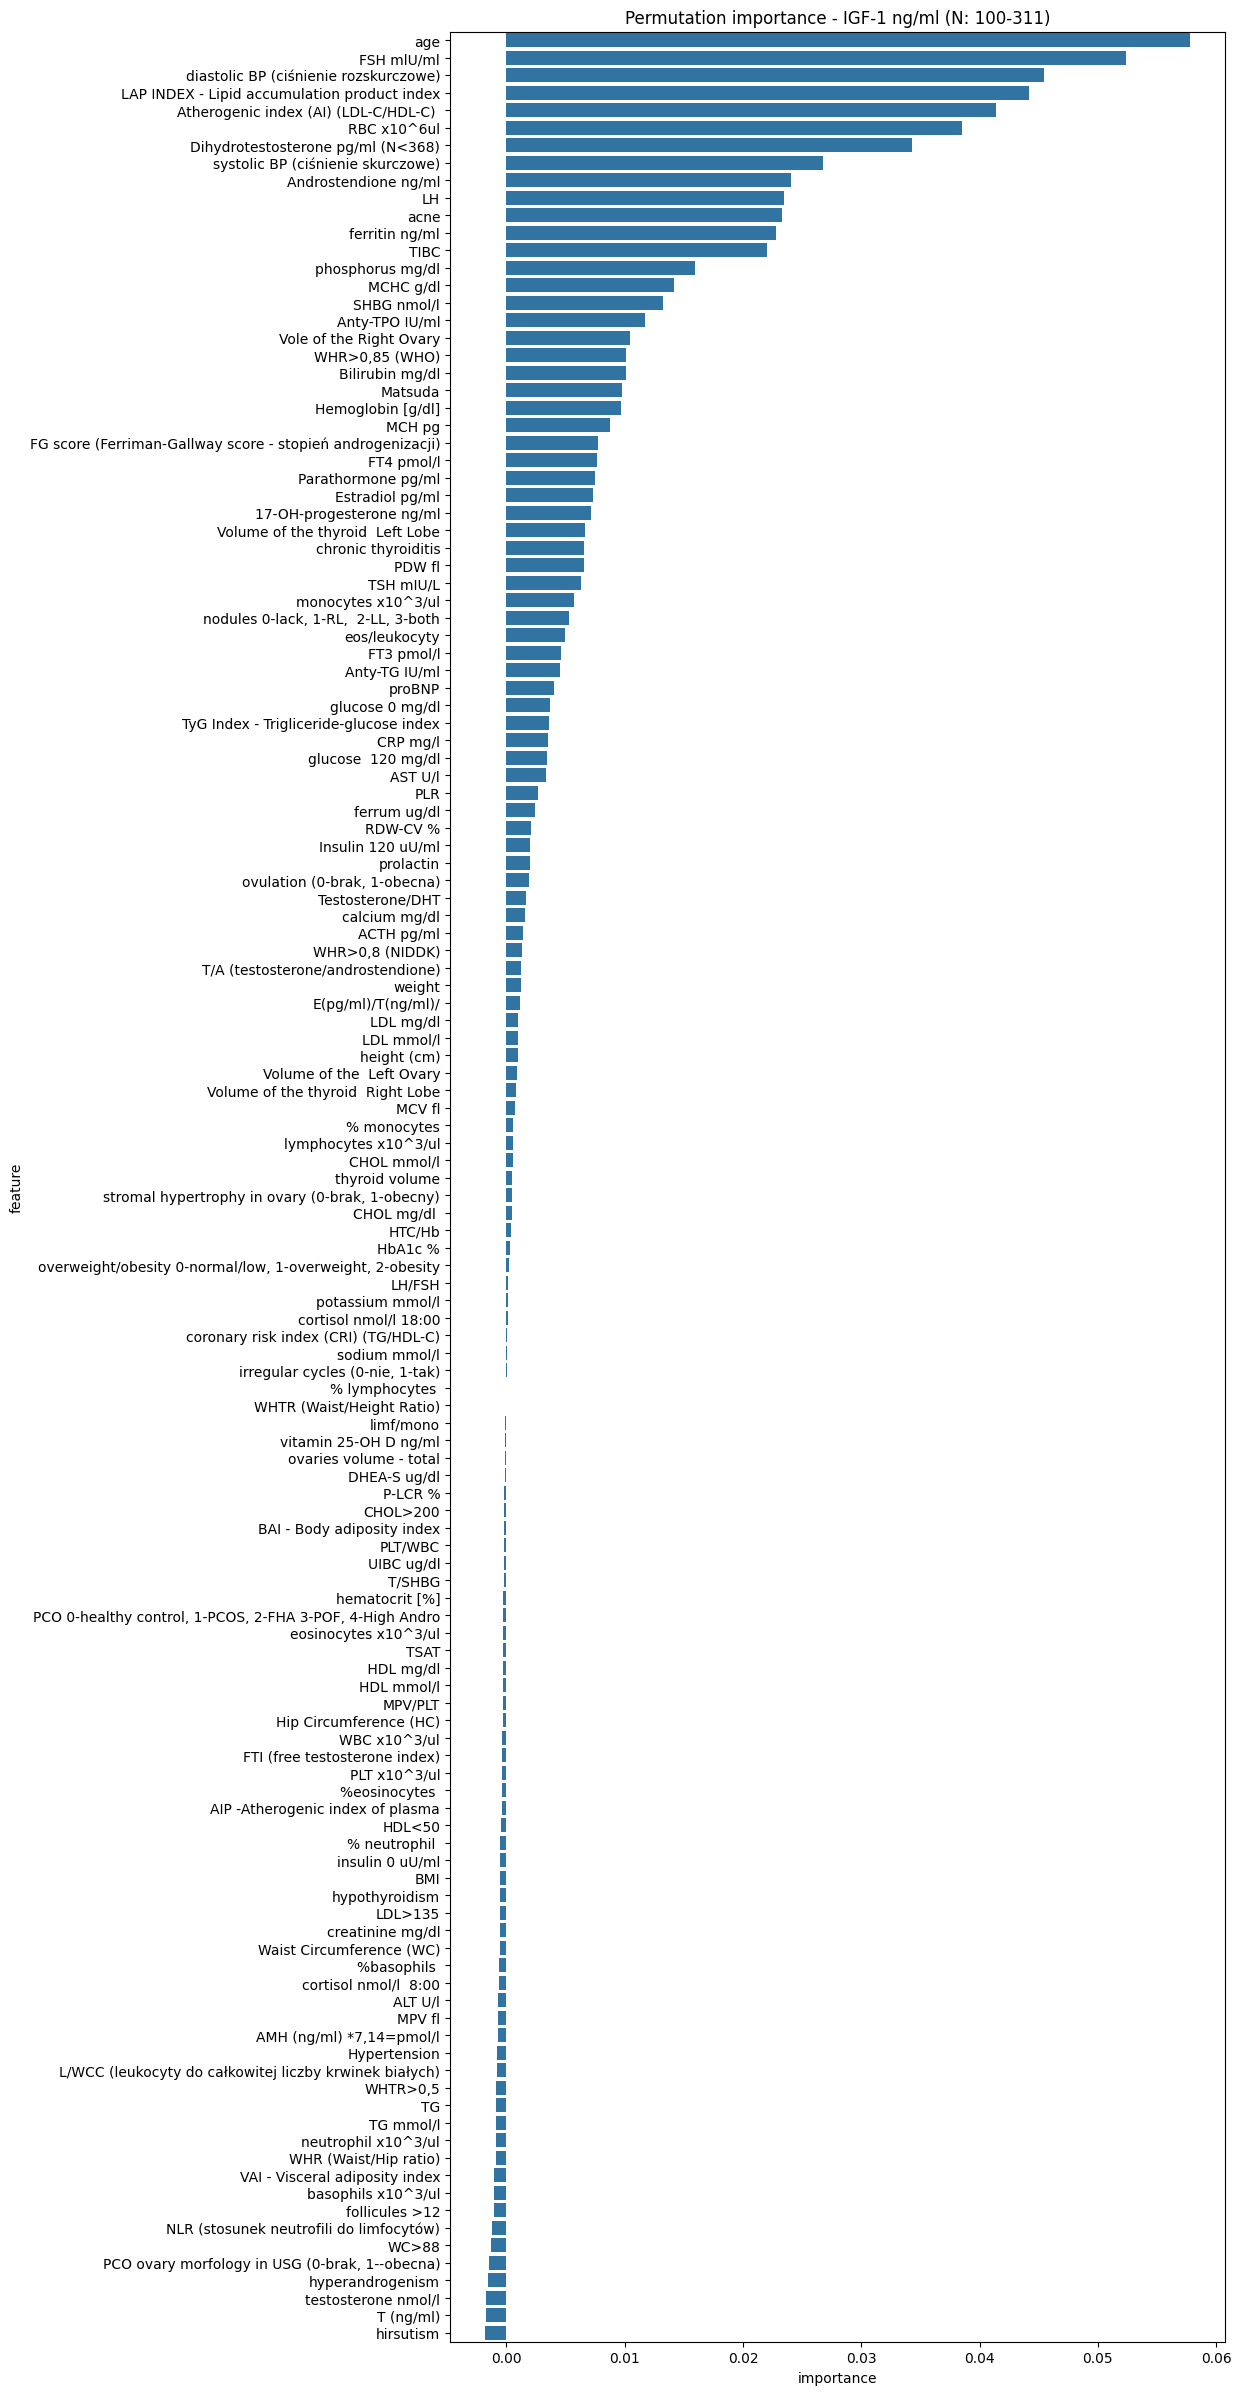

Actually selected 58 features


In [20]:
# NOTE: cropped featureset

lasso_model = Lasso(alpha=1)

selected_features_permutation_importance = get_permutation_importance(X_train_igf[cropped_featureset], y_train_igf, lasso_model, continuous_preprocessor, categorical_preprocessor, IGF)
selected_features_permutation_importance = selected_features_permutation_importance[selected_features_permutation_importance['importance'] > 0.001]
selected_features_map['permutation_importance'] = list(selected_features_permutation_importance['feature'].values)
print(f'Actually selected {len(selected_features_map['permutation_importance'])} features')
# selected_features_permutation_importance

In [43]:
# NOTE: cropped featureset,  only mutual info &  permutation importance
intersection_all_sets = set(selected_features_map[next(iter(selected_features_map))])

for key, items in selected_features_map.items():
    intersection_all_sets.intersection_update(items)


intersection_all_sets = list(intersection_all_sets)
print(len(intersection_all_sets))
print(intersection_all_sets)

pd.DataFrame(intersection_all_sets)

7
['coronary risk index (CRI) (TG/HDL-C)', 'TyG Index - Trigliceride-glucose index', 'Atherogenic index (AI) (LDL-C/HDL-C) ', 'VAI - Visceral adiposity index', 'AIP -Atherogenic index of plasma', 'LAP INDEX - Lipid accumulation product index', 'FTI (free testosterone index)']


0
0          coronary risk index (CRI) (TG/HDL-C)
1        TyG Index - Trigliceride-glucose index
2         Atherogenic index (AI) (LDL-C/HDL-C) 
3                VAI - Visceral adiposity index
4              AIP -Atherogenic index of plasma
5  LAP INDEX - Lipid accumulation product index
6                 FTI (free testosterone index)

In [44]:
intersection_all_sets = set(selected_features_map[next(iter(selected_features_map))])

for key, items in selected_features_map.items():
    intersection_all_sets.intersection_update(items)


intersection_all_sets = list(intersection_all_sets)
print(len(intersection_all_sets))
print(intersection_all_sets)

pd.DataFrame(intersection_all_sets)

7
['coronary risk index (CRI) (TG/HDL-C)', 'TyG Index - Trigliceride-glucose index', 'Atherogenic index (AI) (LDL-C/HDL-C) ', 'VAI - Visceral adiposity index', 'AIP -Atherogenic index of plasma', 'LAP INDEX - Lipid accumulation product index', 'FTI (free testosterone index)']


0
0          coronary risk index (CRI) (TG/HDL-C)
1        TyG Index - Trigliceride-glucose index
2         Atherogenic index (AI) (LDL-C/HDL-C) 
3                VAI - Visceral adiposity index
4              AIP -Atherogenic index of plasma
5  LAP INDEX - Lipid accumulation product index
6                 FTI (free testosterone index)

In [45]:
union_all_sets = set(selected_features_map[next(iter(selected_features_map))]) 

for key, items in selected_features_map.items():
    union_all_sets.update(items)
    

union_all_sets = list(union_all_sets)
print(len(union_all_sets))
print(union_all_sets)

8
['coronary risk index (CRI) (TG/HDL-C)', 'TyG Index - Trigliceride-glucose index', 'VAI - Visceral adiposity index', 'Atherogenic index (AI) (LDL-C/HDL-C) ', 'BAI - Body adiposity index', 'AIP -Atherogenic index of plasma', 'LAP INDEX - Lipid accumulation product index', 'FTI (free testosterone index)']


## Test the narrowed down feature space

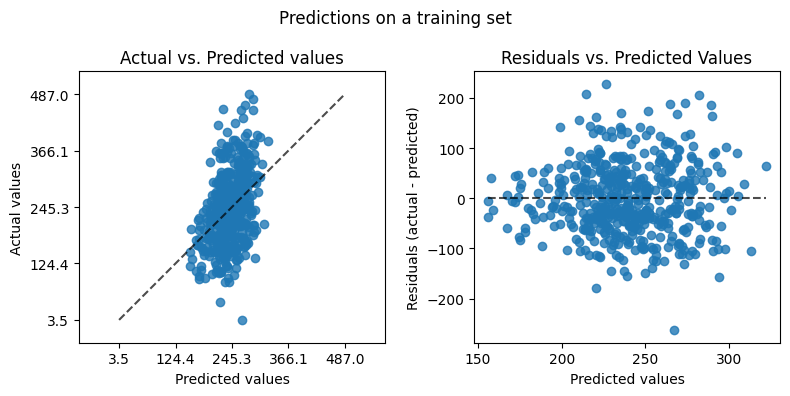

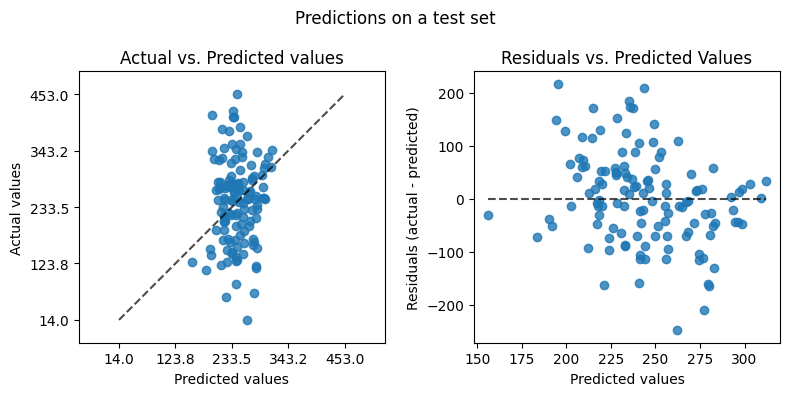

model  data_set       mse     mae    rmse     r2
0  KNeighborsRegressor(n_neighbors=9)  training  5022.035  57.034  70.866  0.152
1  KNeighborsRegressor(n_neighbors=9)      test  7362.287  66.992  85.804 -0.088

In [48]:
knn_model = KNeighborsRegressor(n_neighbors=9)


vit_d_model_scores_df, feature_importnces_knn = train_model(knn_model, IGF, X_train_igf[union_all_sets], y_train_igf, X_test_igf[union_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_knn)
vit_d_model_scores_df

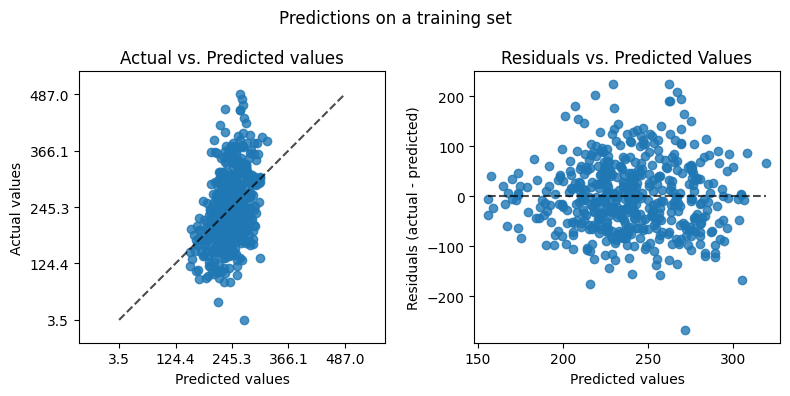

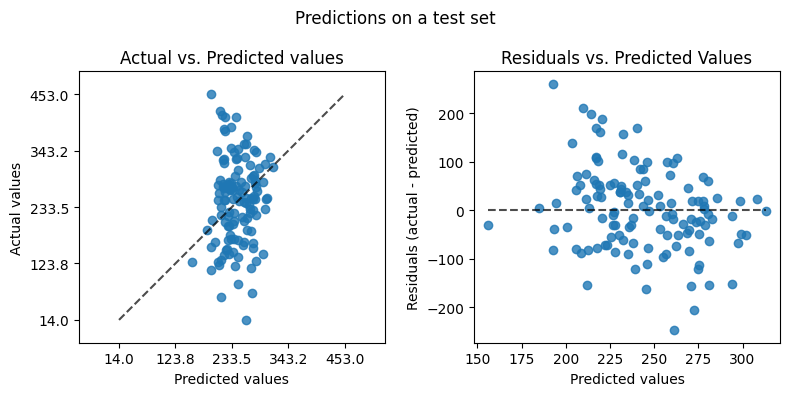

model  data_set       mse     mae    rmse     r2
0  KNeighborsRegressor(n_neighbors=9)  training  5019.116  56.246  70.846  0.152
1  KNeighborsRegressor(n_neighbors=9)      test  7333.503  66.295  85.636 -0.083

In [47]:
knn_model = KNeighborsRegressor(n_neighbors=9)


vit_d_model_scores_df, feature_importnces_knn = train_model(knn_model, IGF, X_train_igf[intersection_all_sets], y_train_igf, X_test_igf[intersection_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_knn)
vit_d_model_scores_df

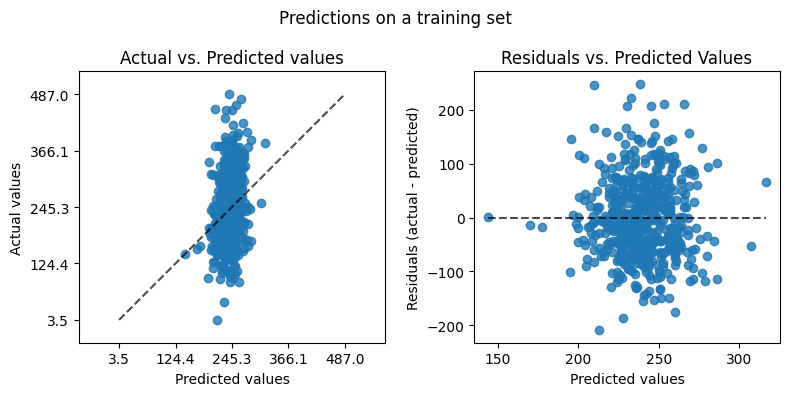

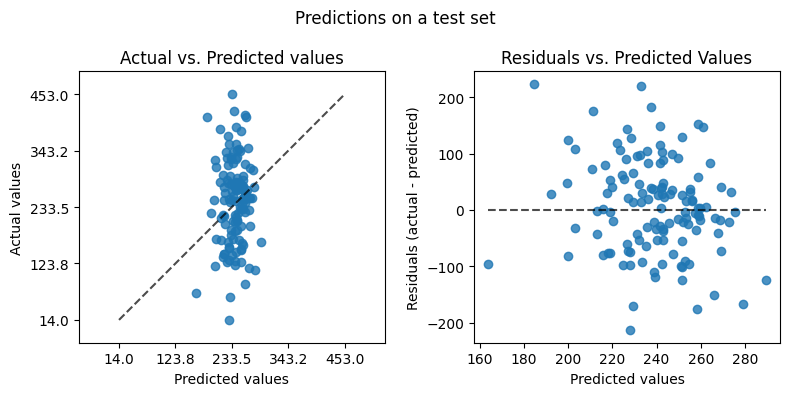

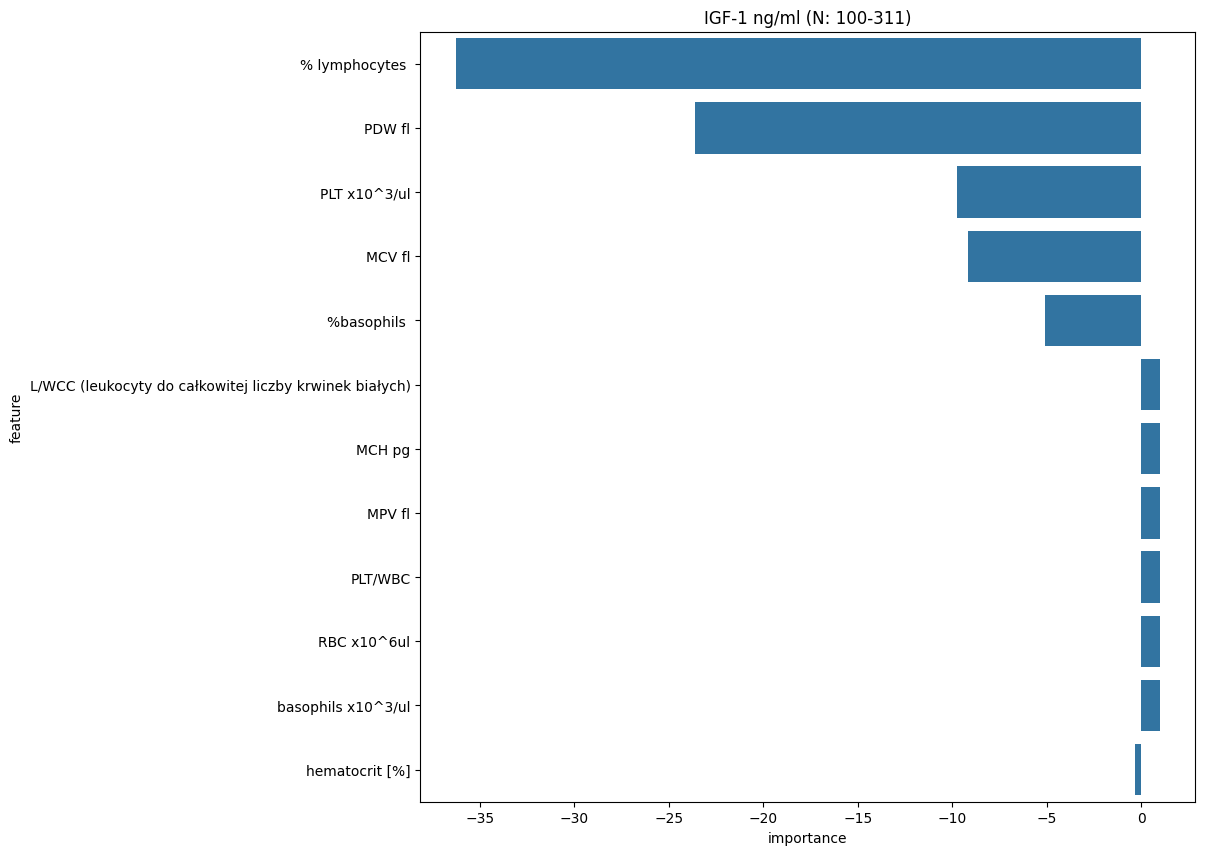

model  data_set       mse     mae    rmse     r2
0  LinearRegression()  training  5561.444  59.580  74.575  0.060
1  LinearRegression()      test  7021.376  66.255  83.794 -0.037

In [24]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, IGF, X_train_igf[intersection_all_sets], y_train_igf, X_test_igf[intersection_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

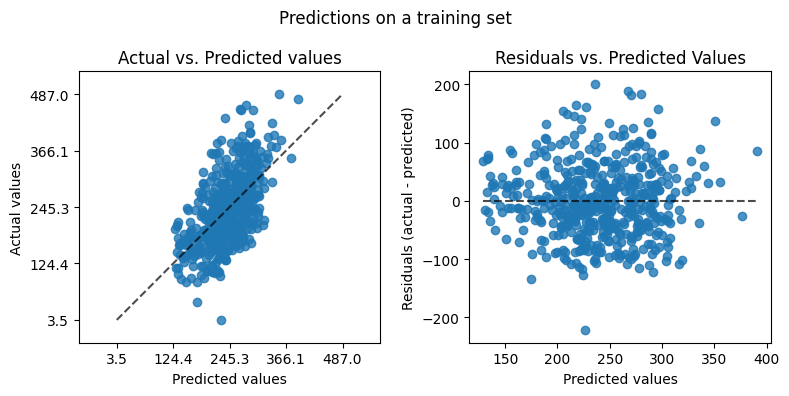

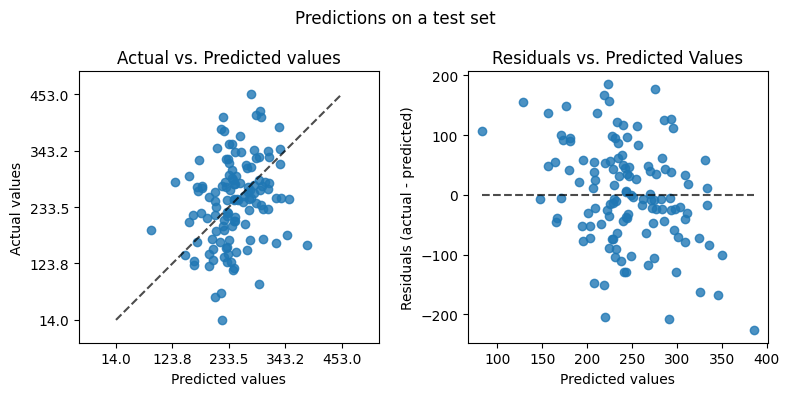

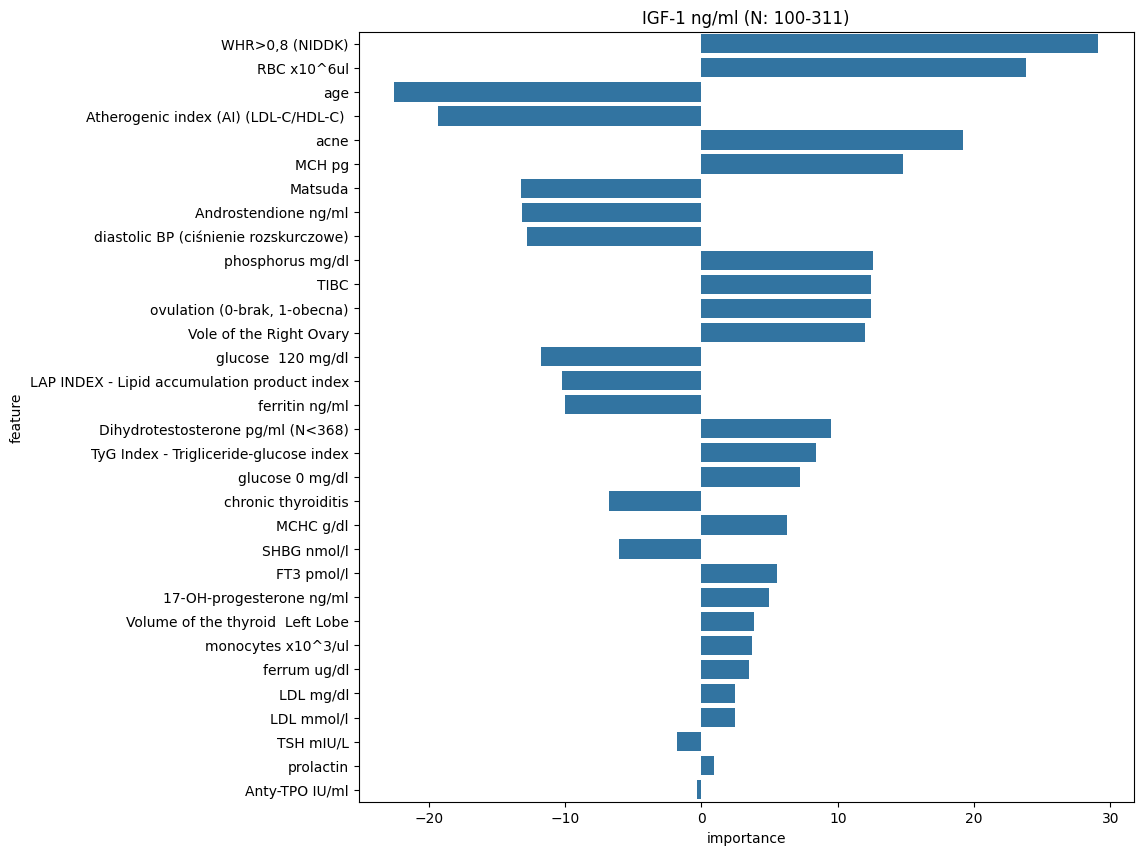

model  data_set       mse     mae    rmse     r2
0  LinearRegression()  training  3835.463  49.077  61.931  0.352
1  LinearRegression()      test  7137.821  67.084  84.486 -0.055

In [22]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, IGF, X_train_igf[intersection_all_sets], y_train_igf, X_test_igf[intersection_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

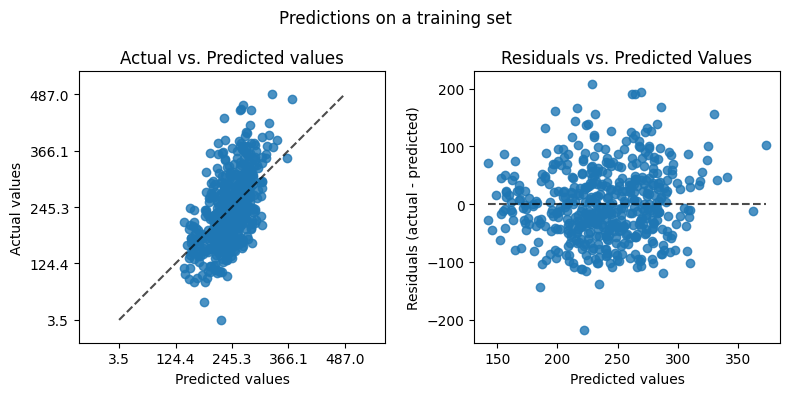

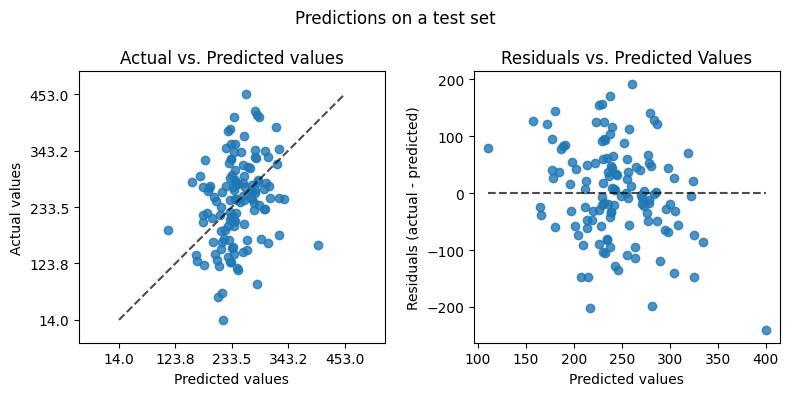

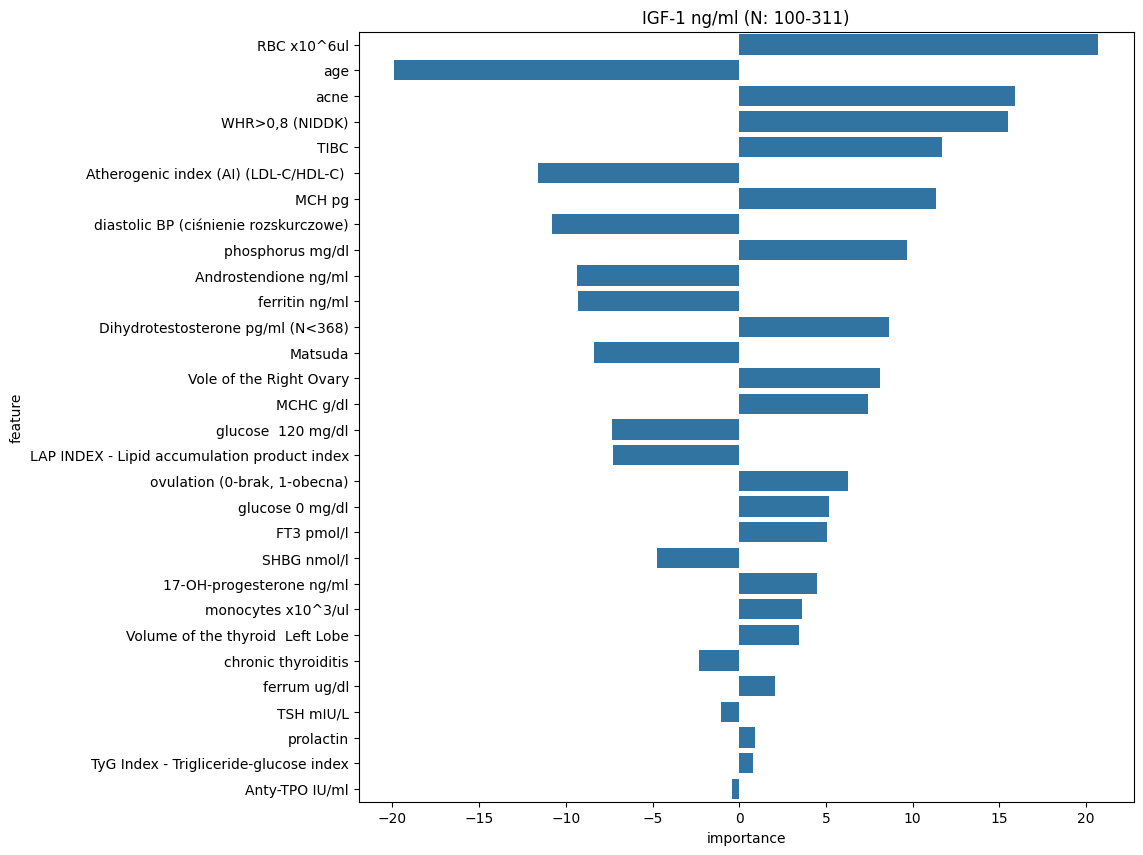

model  data_set       mse     mae    rmse     r2
0  Lasso(alpha=1)  training  3920.132  49.835  62.611  0.338
1  Lasso(alpha=1)      test  6798.412  65.473  82.452 -0.004

In [23]:
lasso_model = Lasso(alpha=1)


vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, IGF, X_train_igf[intersection_all_sets], y_train_igf, X_test_igf[intersection_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

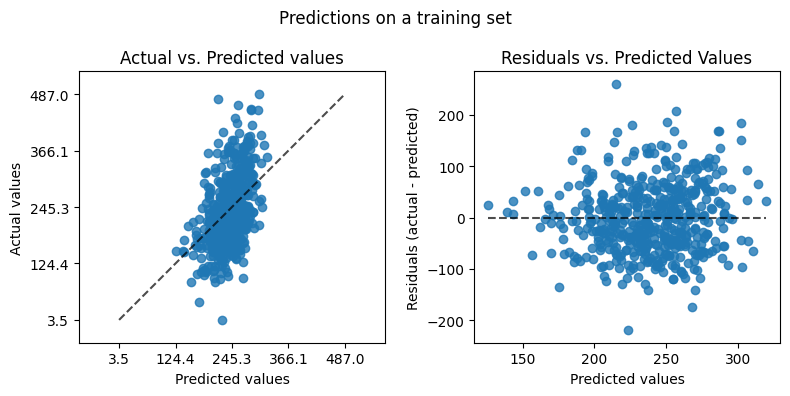

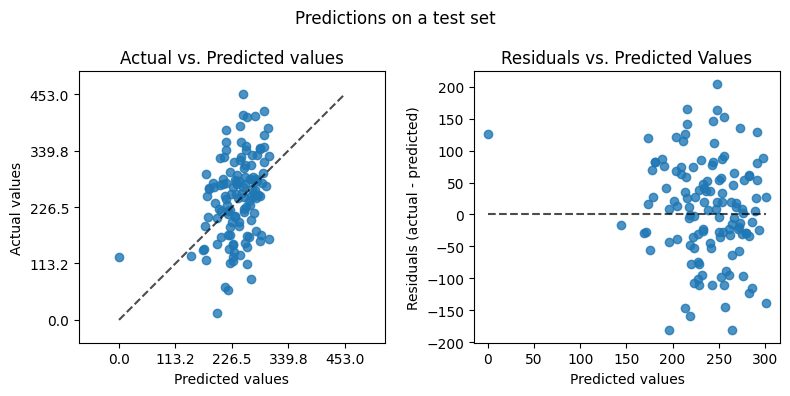

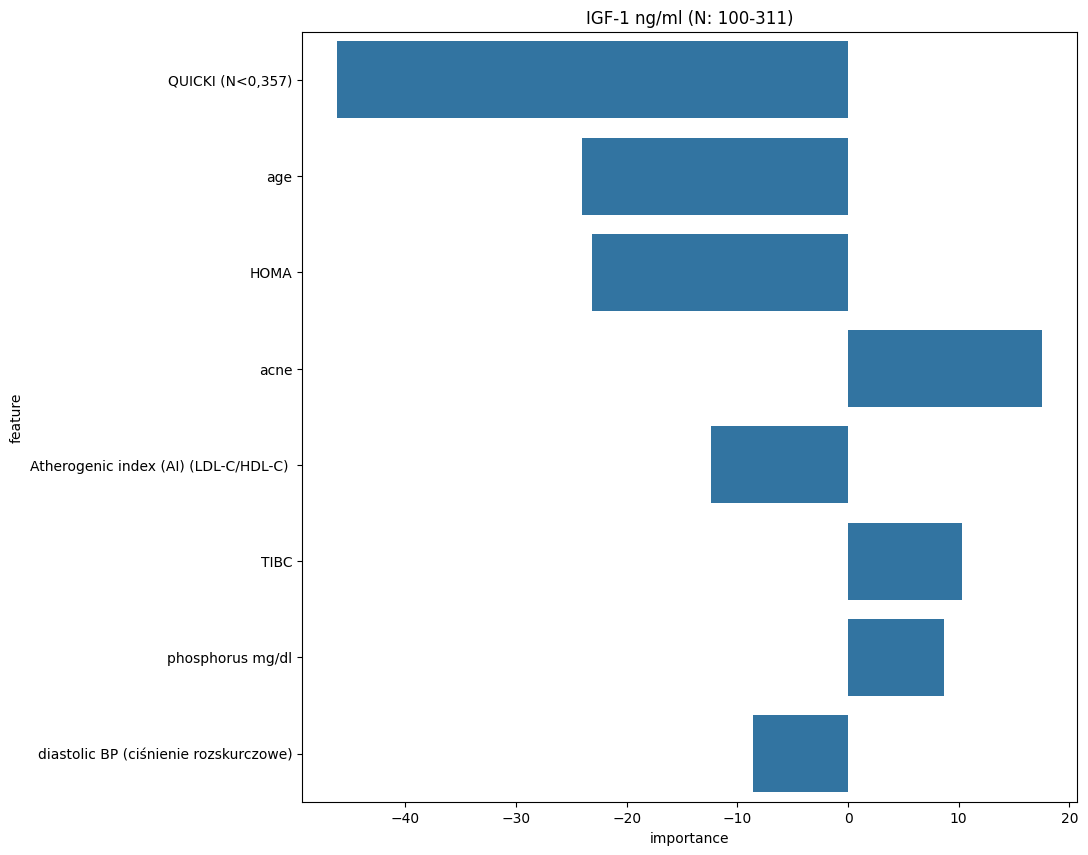

model  data_set       mse     mae    rmse     r2
0  Lasso(alpha=1)  training  4606.391  54.457  67.870  0.222
1  Lasso(alpha=1)      test  6164.515  62.860  78.514  0.089

In [70]:
lasso_model = Lasso(alpha=1)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, IGF, X_train_igf[intersection_all_sets], y_train_igf, X_test_igf[intersection_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

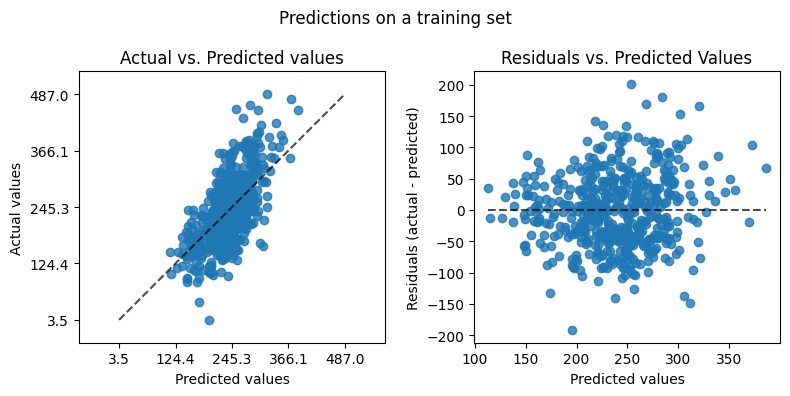

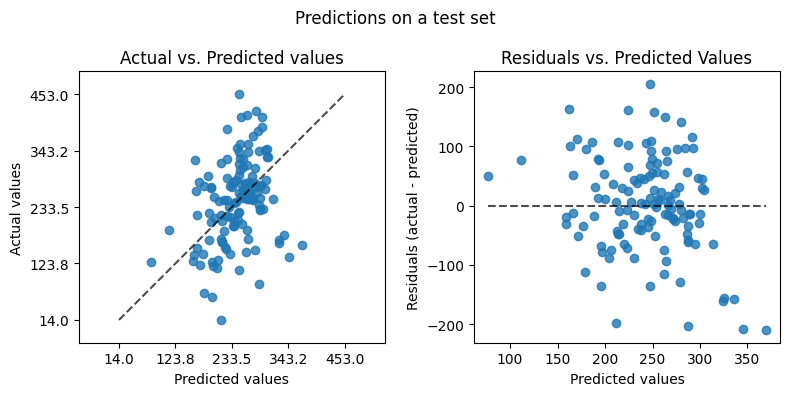

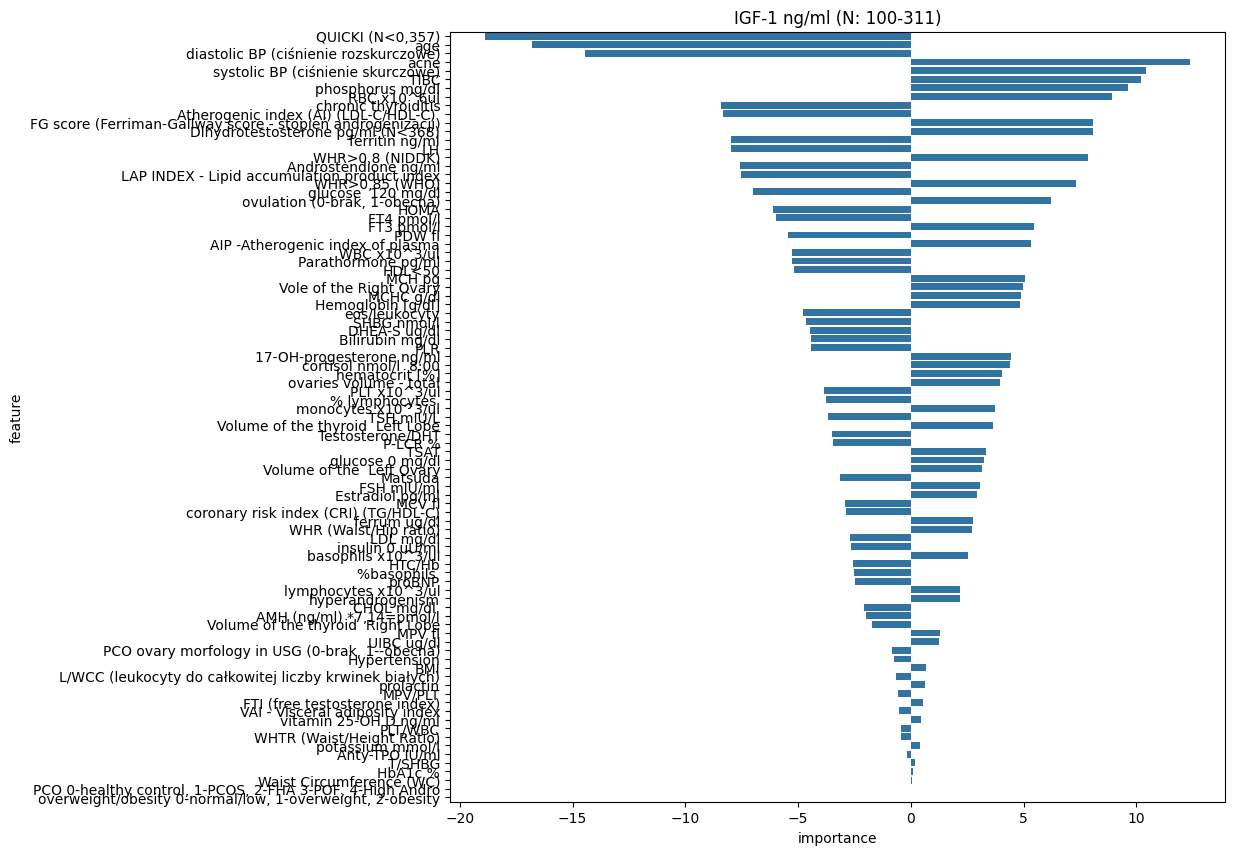

model  data_set       mse     mae    rmse     r2
0  Ridge(alpha=50)  training  3387.853  46.920  58.205  0.428
1  Ridge(alpha=50)      test  6520.451  62.431  80.749  0.037

In [71]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, IGF, X_train_igf[union_all_sets], y_train_igf, X_test_igf[union_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

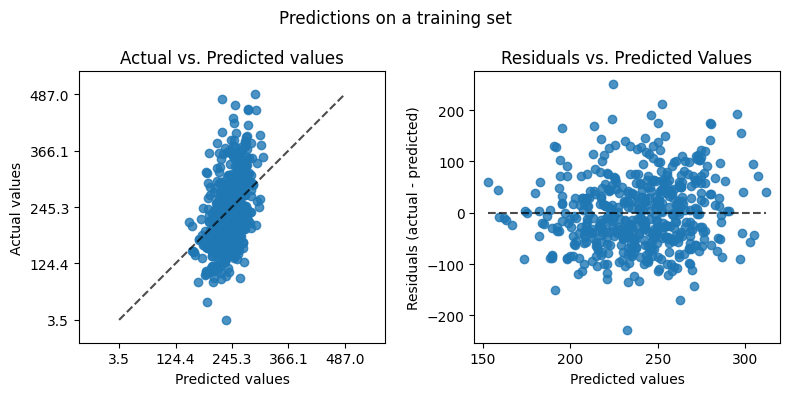

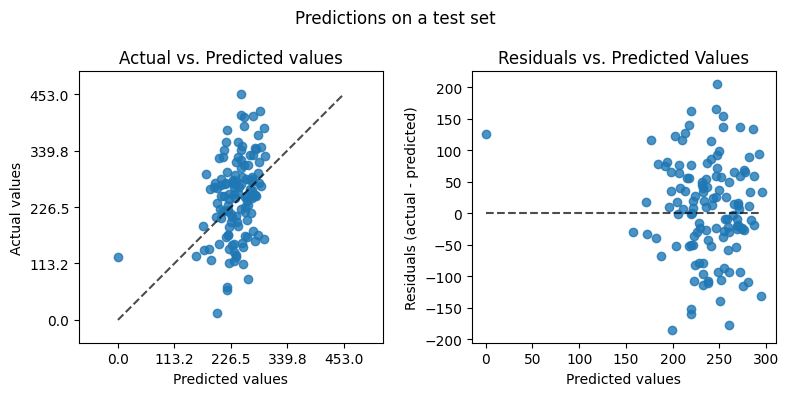

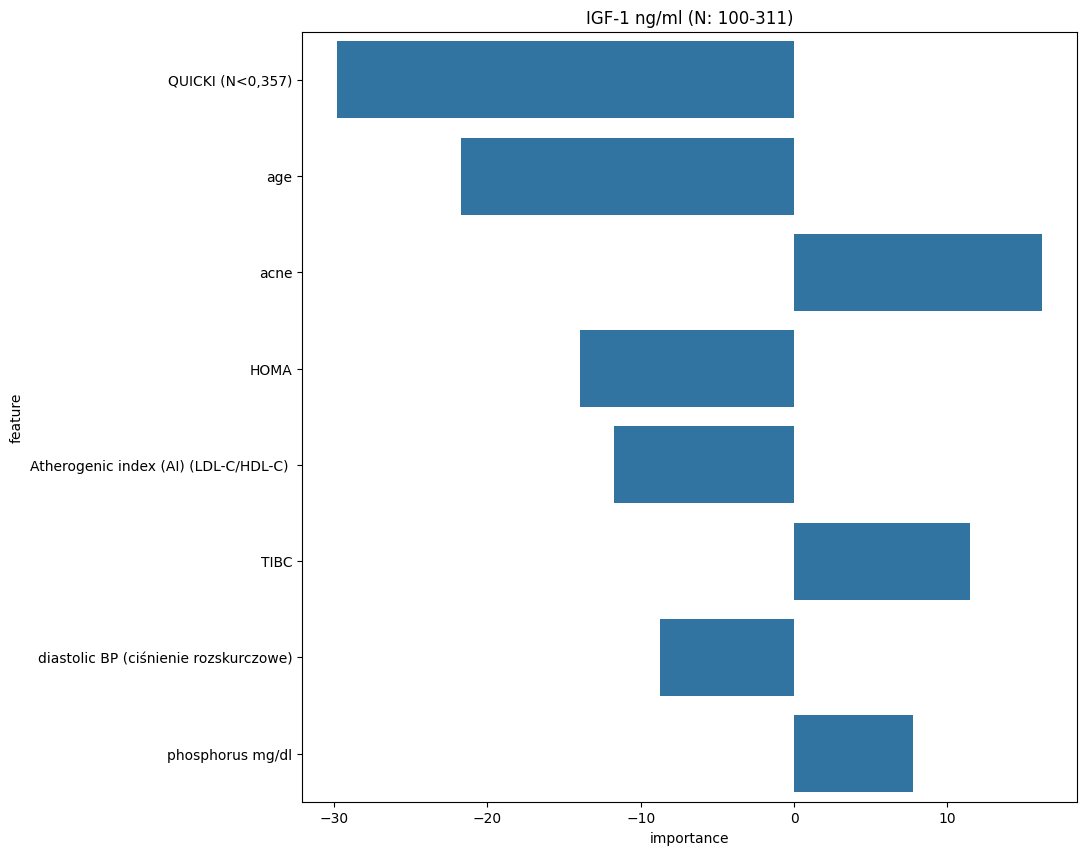

model  data_set       mse     mae    rmse     r2
0  Ridge(alpha=50)  training  4704.495  55.129  68.589  0.205
1  Ridge(alpha=50)      test  6141.732  62.840  78.369  0.093

In [72]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, IGF, X_train_igf[intersection_all_sets], y_train_igf, X_test_igf[intersection_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df